# Boosting Vaccination Rates

### Making Healthier Communities

by Three Sweaters Consulting

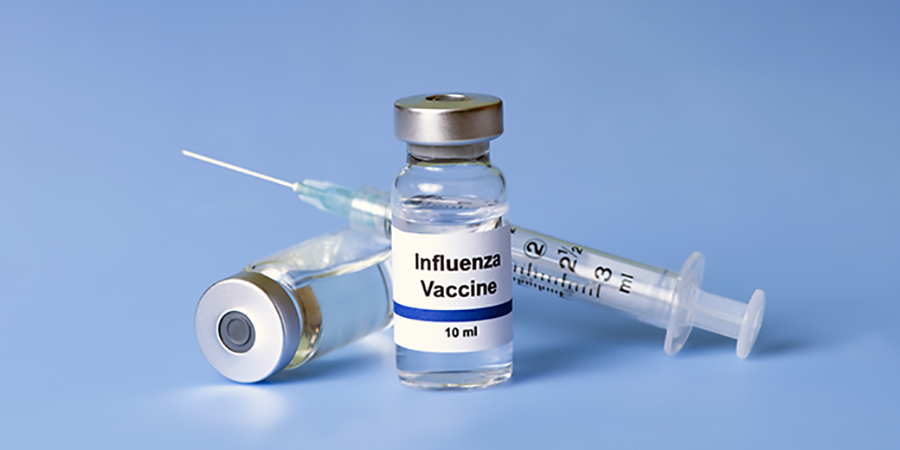

During the spring of 2009, a new contagion raced around the world. This novel strain of influenza A (AKA “Swine Flu) infected 60 million people worldwide and caused between 151,000-575,400 deaths within one year. Unlike the seasonal flu, H1N1 primarily sickened young people. A vaccine to the H1N1 virus was developed in the fall of 2009, but it was too late to be included in the seasonal flu vaccine for that year. This necessitated receiving 2 different flu vaccines for the flu season of 2009-10.

To help monitor H1N1 and seasonal vaccine rates, the Centers for Disease Control (CDC), along with other agencies, conducted a nationwide survey from September 2009 through June 2010. The target population was anyone living in the country who was at least 6 months old. Covering a wide range of health, opinion and demographic questions, over 70,000 household interviews were conducted. These responses comprise the National 2009 H1N1 Flu Survey (NHFS), the dataset upon which this study is based.

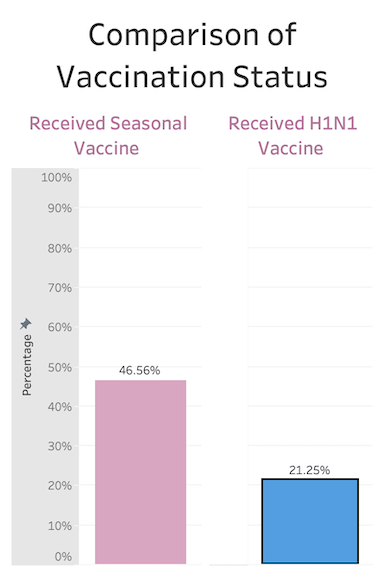 

The version of the NHFS available at DrivenData contains survey responses from 26,707 individuals. There are 2 target variables–whether or not someone received the H1N1 vaccine and whether or not someone received the seasonal influenza vaccine. This study will examine the probabilities of an individual getting these vaccines. Of the respondents, 14,272 did not receive the seasonal flu vaccine and 12,435 did. These amounts are roughly symmetrical while the number of people who did not receive the H1N1 vaccine far surpasses the number who did (21,033 to 5,674). This presents an obvious class imbalance, with those who received the H1N1 vaccine comprising about 20% of the respondents. 

Knowing that the next pandemic is a matter of "when" rather than "if," federal agencies are searching for ways to increase vaccination rates. These organizations have contracted our company, 3 Sweaters Consulting, to study the NHFS to better understand why people did or did not receive the flu/H1N1 vaccine. Using the insights gained from our study, we will provide recommendations regarding public health outreach and policy, with the goal of increasing vaccination rates.

(Note: the above and a few other graphs were made in Tableau, so there will be no code for them here in the notebook.)

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.inspection import plot_partial_dependence

import time
import datetime
import pickle
import eli5

from eli5.sklearn import PermutationImportance

# Next two imports only necessary if target classes are imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.set_option("display.max_columns", 50)
%matplotlib inline

random_state = 1232022

with open('data/model_scoring_dict.pickle', 'rb') as f:
    model_scoring_dict = pickle.load(f)

with open('data/models_dict.pickle', 'rb') as f:
    models_dict = pickle.load(f)
    
"""
Note: the full models_dict.pickle file is too large to be hosted on github, so the version available in the repo
is an older smaller one. To use the full file, one can either run each of the models available in this notebook,
which, besides the Support Vector Machine models, don't actually take that long to run, or the full pickle files
can be downloaded from here: https://drive.google.com/drive/folders/1vVga_rfuCLoPhoDb3encokDiEy61_VYJ?usp=sharing
The model_scoring_dict is also older, though its data merely duplicates a portion of models_dict, but it too can
be downloaded from the link above.
""";

In [5]:
# Use this cell to reset the model dictionaries
#model_scoring_dict = {}
#models_dict = {}

### Importing the data

Because this dataset is part of a competition and a train-test split has already been performed, we'll treat the training data as the entire dataset. That way, we can perform our own train-test split, and, subsequently, we'll be able to acquire test scores of our own without necessarily having to submit to the competition. However, if at any point we're satisfied with a model, we can use that model to make predictions on the competition's original test data and submit those predictions to the competition if we so wish. As such, we'll import the competition's testing data as 'y_test_comp'.

We'll also combine our X and y into a single dataframe in case we need it for EDA, graphs, cleaning or the like.

In [6]:
X = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

df = pd.concat([X, y], axis=1)

X_test_comp = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')
submission_df = pd.read_csv('data/submission_format.csv', index_col="respondent_id")

We'll first check to see if the classes are imbalanced.

In [7]:
print(y['h1n1_vaccine'].value_counts())
print(y['seasonal_vaccine'].value_counts())

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


It looks as though the seasonal vaccine classes are very balanced, while the H1N1 vaccine classes are less so, with the minority class comprising about 20% of the samples. This is not necessarily a huge problem, so we won't do anything about it right this second, but we may revisit the issue after we get a first rough model built.

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [9]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


### To Pipeline? Or not to Pipeline?

For now, while exploring and experimenting with the data, we'll do things manually. Once we've settled on some models and cleaning strategies, we'll refactor the code into a pipeline.

# First Model: Basic Logistic Regression

To begin, we'll fit a basic logistic regression to the data. The only thing we'll do to prepare the data is to impute missing values (since most categories, including the numeric ones, are categorical, we'll go with the mode), one-hot encode the non-numeric columns, and scale the numeric columns. But first, a train-test split!

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [11]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

In [12]:
numeric_columns = list(X_train.columns[X_train.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)

### Simple Imputer

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

### One Hot Encoder

In [14]:
X_train_obj = X_train_imp[obj_columns]
X_test_obj = X_test_imp[obj_columns]

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

X_train_ohe = pd.concat([X_train_imp[numeric_columns], X_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_imp[numeric_columns], X_test_ohe], axis=1)

### Standard Scaler

In [15]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

## Fitting the model

There is a class called MultiOutputClassifier that we could use here that would run regressions for both class labels at the same time, but, even though it's convenient for training, it can be slightly less convenient for scoring and analyzing, so for every model we fit for the H1N1 vaccine, we'll fit a second model for the seasonal flu vaccine as well.

In [16]:
log_reg_h1n1 = LogisticRegression()
log_reg_ssnl = LogisticRegression()

log_reg_h1n1.fit(X_train_scaled, y_train_h1n1)
log_reg_ssnl.fit(X_train_scaled, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [17]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_scaled)
y_hat_ssnl = log_reg_ssnl.predict(X_test_scaled)

In [18]:
y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_scaled)

In [19]:
cf_matrix_h1n1 = confusion_matrix(y_test_h1n1, y_hat_h1n1)
cf_matrix_ssnl = confusion_matrix(y_test_ssnl, y_hat_ssnl)

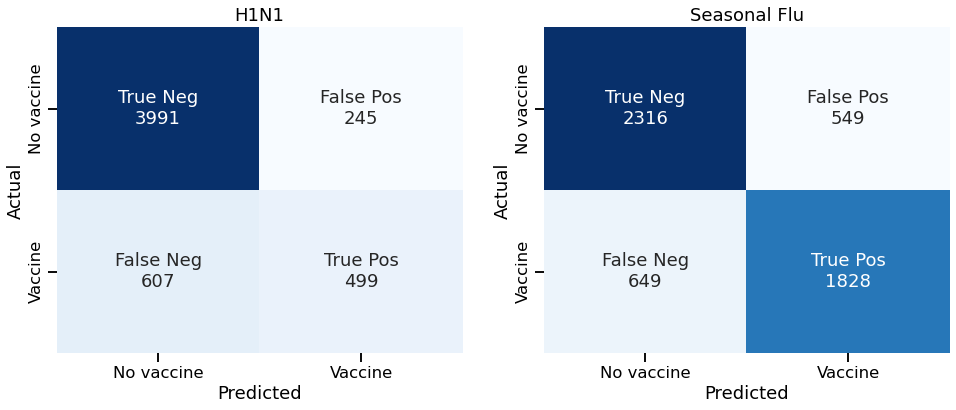

In [20]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['No vaccine', 'Vaccine']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix_h1n1.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

group_counts_2 = ['{0:0.0f}'.format(value) for value in cf_matrix_ssnl.flatten()]
labels_2 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_2)]
labels_2 = np.asarray(labels_2).reshape(2,2)

sns.set_context('talk')
fig, (ax1, ax2)= plt.subplots(figsize=(16,6), ncols=2)

sns.heatmap(cf_matrix_h1n1, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax1)
ax1.set_ylabel('Actual')
ax1.set_yticklabels(ax1.get_yticklabels(), va="center")
ax1.set_xlabel('Predicted')
ax1.set_title('H1N1')

sns.heatmap(cf_matrix_ssnl, annot=labels_2, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax2)
ax2.set_ylabel('Actual')
ax2.set_yticklabels(ax2.get_yticklabels(), va="center")
ax2.set_xlabel('Predicted')
ax2.set_title('Seasonal Flu');

In [21]:
print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl[:,1])}')

Recall for H1N1:            0.4511754068716094
Recall for seasonal flu:    0.7379895034315704

Precision for H1N1:         0.6706989247311828
Precision for seasonal flu: 0.769036600757257

Accuracy for H1N1:          0.8405091725945338
Accuracy for seasonal flu:  0.775739423436915

F1 score for H1N1:          0.5394594594594594
F1 score for seasonal flu:  0.753193242686444

AUROC for H1N1:             0.8396438774168541
AUROC for seasonal flu:     0.8492191688842763


# More precise cleaning and refactoring into a pipeline

Now that we've got a basic and working but still fairly rough model, we'll sort out a more precise cleaning routine. Once we've done that, we'll refactor it into a pipeline. We'll do these two separate steps because certain tests and optimizations won't play nicely with our pipeline objects, so it will be necessary to have the cleaned data available outside of the pipeline as well as inside.

We'll also code some of our graphing and scoring steps as a function so we can easily spit out several metrics for each model.

As our first step in re-cleaning, we'll also redo our train-test split with stratify because the H1N1-vaccinated class is slightly imbalanced. It likely won't be a drastic improvement, but we may be able to squeeze a small amount of extra juice out of any models going forward.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y['h1n1_vaccine'], random_state=random_state)

In [23]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl = y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl = y_test.iloc[:,1]

In [24]:
# Without this cell, a number of future cells will produce a SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()
y_train_h1n1 = y_train_h1n1.copy()
y_train_ssnl = y_train_ssnl.copy()
y_test_h1n1 = y_test_h1n1.copy()
y_test_ssnl = y_test_ssnl.copy()

In [25]:
numeric_columns = list(X_train.columns[X_train.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)
all_columns = list(X_train.columns.values)

### Two preprocessors, one for tree-based models, one for anything else

On closer inspection of the data, it's clear that the entire dataset is actually categorical. As such, our logistic regression would likely benefit from the whole dataset being one-hot encoded. On the other hand, tree-based models won't necessarily benefit from one-hot encoding, and a good deal of the categorical data is ordinal, which would benefit from scaling.

So one preprocessor will impute missing values and then one-hot encode every feature. The other processor will impute missing values, encode certain ordinal categories as numerical, and then min-max scale all ordinal features.

### The common pipeline

The pipelines can become somewhat complicated when attempting to run multiple imputers on different sets of columns. Because of this, we'll make a custom imputer function specifically for this dataset that runs before things feed into the pipeline. This is all necessary because three of our columns have nearly half of their values missing. It seems not quite right to replace them with the mode or median (like we'll do with the rest of the columns), but we also certainly don't want to be dropping ten-thousand datapoints. So for those we'll impute their missing values by hand with 'unknown', or in the case of health_insuarance, which is binary, with 2 (which will act more or less like 'unknown'). 

We'll also ordinally encode certain columns by hand (age_group, education, and income_poverty) for similar reasons. 

### The custom imputer

In [26]:
def impute_unk(df):
    df.loc[df['employment_industry'].isna(), 'employment_industry'] = 'unknown'
    df.loc[df['employment_occupation'].isna(), 'employment_occupation'] = 'unknown'
    df.loc[df['health_insurance'].isna(), 'health_insurance'] = 2
    
    for column in df:
        if df[column].isnull().any():
            df[column]=df[column].fillna(df[column].mode()[0])

In [27]:
def ord_encode(df):
    
    """
    This function takes a dataframe and encodes some of the
    categorical variables as ordinal, according to a pre-defined
    list of values. This operation is in place.
    """

    df = pd.DataFrame(df)
    
    age_group_values = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
    education_values = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
    income_poverty_values = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

    values_dict = {'age_group': age_group_values, 'education': education_values, 'income_poverty': income_poverty_values}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)

In [28]:
def clean(df):
    impute_unk(df)
    ord_encode(df)

In [29]:
clean(X_train)
clean(X_test)
clean(X_test_comp)

### And our two paths for different model types

For linear models, because the dataset is entirely categorical, we'll one-hot encode the entire thing. For tree-based models, we'll one-hot encode the columns whose datatype is object and we'll minmax scale the rest.

### Linear models:

Just one-hot encoding

In [30]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_train_linear = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names(), index=X_train.index)
X_test_linear = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names(), index=X_test.index)

### Tree-based models:

One-hot encoding and minmax scaling

In [31]:
X_train_ohe_t = pd.DataFrame(ohe.fit_transform(X_train[obj_columns]), columns=ohe.get_feature_names(), index=X_train[obj_columns].index)
X_test_ohe_t = pd.DataFrame(ohe.transform(X_test[obj_columns]), columns=ohe.get_feature_names(), index=X_test[obj_columns].index)

In [32]:
mm = MinMaxScaler()

X_train_scaled_t = pd.DataFrame(mm.fit_transform(X_train[numeric_columns]), columns=X_train[numeric_columns].columns, index=X_train[numeric_columns].index)
X_test_scaled_t = pd.DataFrame(mm.transform(X_test[numeric_columns]), columns=X_test[numeric_columns].columns, index=X_test[numeric_columns].index)

In [33]:
X_train_tree = pd.concat([X_train_scaled_t, X_train_ohe_t], axis=1)
X_test_tree = pd.concat([X_test_scaled_t, X_test_ohe_t], axis=1)

### Pipelines made easy

In order to run loads of models more quickly and conveniently, we'll put our pipeline into a function that takes an estimator and a choice of preprocessor and then fits the model, produces predictions, and then scores the model by passing those predictions to another scoring and graphing function.

In [34]:
def train_new_model(estimators, preprocessor, grid=None, model_name=['H1N1', 'Seasonal Flu'], keep_score=False, suppress_output=False):
    """
    This function takes in a tuned estimator as well as a choice of a preprocessor
    and returns a number of scoring metrics. It also saves the model and it's
    results in a scoring dictionary. It can alternatively do a grid search if passed
    a grid list. Scoring output can be suppressed with suppress_output=True.
    
    Note: The grid search feature is not yet functional.
    
    estimator: a list containing the classes of the regressor or classifier to be modeled. 
    Any desired hyperparameters should be included 
    (e.g. [LogisticRegression(max_iter=1000), LogisticRegression(max_iter=1000)]).
    Technically speaking, the estimators do not need to be the same, but the function is
    designed to run the same type of model on H1N1 and the seasonal flu, so
    
    preprocessor: string - 'linear' or 'tree'
    
    grid: a list of hyperparameters with which do do a grid search
    
    suppress_output: bool
    """
    
    ohe_transform = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), all_columns)])
    
    linear_preprocessor1 = Pipeline(
        steps=[
            ('ohe', ohe_transform),
            ('est', estimators[0])
        ])

    linear_preprocessor2 = Pipeline(
        steps=[
            ('ohe', ohe_transform),
            ('est', estimators[1])
        ])
    
    tree_transformer = ColumnTransformer(
        transformers=[
            ('minmax', MinMaxScaler(), numeric_columns),
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), obj_columns)
        ])
    
    tree_preprocessor1 = Pipeline(
        steps=[
            ('tree', tree_transformer),
            ('est', estimators[0])
        ])
    
    tree_preprocessor2 = Pipeline(
        steps=[
            ('tree', tree_transformer),
            ('est', estimators[1])
        ])
        
    if preprocessor == 'linear':
        pipe1 = linear_preprocessor1
        pipe2 = linear_preprocessor2
    elif preprocessor == 'tree':
        pipe1 = tree_preprocessor1
        pipe2 = tree_preprocessor2
        
    if grid:
        pass
    
    else:
        
        global models_dict
        global y_proba_h1n1_comp
        global y_proba_ssnl_comp
        
        def create_entry(i):
            
            dictionary_entry = {'estimator': None, 
                                'preprocessor': None, 
                                'fitted_estimator': None, 
                                'scores': None,
                                'predictions': None,
                                'time_run': None
                               }
            
            dictionary_entry['estimator'] = estimators[i]
            dictionary_entry['preprocessor'] = preprocessor
            dictionary_entry['fitted_estimator'] = fitted_estimator
            dictionary_entry['predictions'] = [y_hat, y_proba, y_proba_comp]
            dictionary_entry['time_run'] = time.asctime()
            models_dict[model_name[i]] = dictionary_entry
        
        clean(X_train)
        clean(X_test)
        clean(X_test_comp)
        
        fitted_estimator = pipe1.fit(X_train, y_train_h1n1)
        y_hat = pipe1.predict(X_test)
        y_hat_h1n1 = y_hat
        y_proba = pipe1.predict_proba(X_test)
        y_proba_h1n1 = y_proba
        y_proba_comp = pipe1.predict_proba(X_test_comp)
        y_proba_h1n1_comp = y_proba_comp
        
        if keep_score:
            create_entry(0)

        fitted_estimator = pipe2.fit(X_train, y_train_ssnl)
        y_hat = pipe2.predict(X_test)
        y_hat_ssnl = y_hat
        y_proba = pipe2.predict_proba(X_test)
        y_proba_ssnl = y_proba
        y_proba_comp = pipe2.predict_proba(X_test_comp)
        y_proba_ssnl_comp = y_proba_comp
        
        if keep_score:
            create_entry(1)
            
        all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=model_name, keep_score=keep_score, suppress_output=suppress_output)

### And a nice big function to score them

This function will take in lists of target data and lists of predictions and probabilities and return a number of scoring metrics as well as print out confusion matrices for quick and easy comprehension.

In [35]:
def all_metrics(y_actuals, y_hats, y_score=None, model_name=None, keep_score=False, save_fig=False, suppress_output=False):
    """
    This function takes in y data either as single dataframes or in groups
    as lists and returns recall, precision, accuracy, and f1 score. 
    If y_score is provided, an AUC score will also be calculated.
    If a name for the model is supplied and keep_score is set to True,
    that name along with scores are stored in a model dictionary for later use. 
    
    y_actuals: array/dataframe or a list of arrays/dataframes
    
    y_hats: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    y_score: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    model_name: string or list of strings. If y_actuals is 
    single array/dataframe, then string. If y_actuals is list, then
    list of same length.
    
    keep_score: bool, saves scores in a score dictionary
    
    save_fig: bool, exports graph to graph folder
    
    suppress_output, bool, if True, scores the model and can additionally
    save scores but does not output any graphs or scoring metrics
    
    Note: save_fig is only supported for single models.
    
    """
    global model_scoring_dict
    global models_dict

    if type(y_actuals) == list:
        if len(y_actuals) != len(y_hats):
            print('The size of each list for y_tests and y_hats needs to be the same size.')
            return
        elif model_name and len(y_actuals) != len(model_name):
            print('The number of names does not match the number of models.')
            return
        else:
            all_scores = {}
            confusion_matrices = []
            for i in list(range(len(y_actuals))):
                y_actual = y_actuals[i]
                y_hat = y_hats[i]
                model_scores = {}
                cf_matrix = confusion_matrix(y_actual, y_hat)
                model_scores['recall'] = recall_score(y_actual, y_hat)
                model_scores['precision'] = precision_score(y_actual, y_hat)
                model_scores['accuracy'] = accuracy_score(y_actual, y_hat)
                model_scores['f1'] = f1_score(y_actual, y_hat)
                if y_score:
                    model_scores['AUC'] = roc_auc_score(y_actual, y_score[i][:,1])
                
                if model_name:
                    all_scores[model_name[i]] = model_scores
                    if keep_score:
                        model_scoring_dict[model_name[i]] = model_scores
                        
                        if model_name[i] not in models_dict:
                            models_dict[model_name[i]] = {}
                        
                        models_dict[model_name[i]]['scores'] = model_scoring_dict[model_name[i]]
            
                else:
                    all_scores[f'model number {i+1}'] = model_scores
                    
                confusion_matrices.append(cf_matrix)
        
        if keep_score:
            competition_score_csv()
            
            with open('data/models_dict.pickle', 'wb') as f:
                pickle.dump(models_dict, f)
            with open('data/model_scoring_dict.pickle', 'wb') as f:
                pickle.dump(model_scoring_dict, f)
        
        if suppress_output:
            return
        
        row = len(all_scores) // 3
        col = len(all_scores) % 3
        
        if len(all_scores) < 4:
            ncols=len(all_scores)
            nrows=1
        else:
            ncols=3
            if col != 0:
                nrows=row+1
            else:
                nrows=row
                
        sns.set_context('talk')
        fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
        
        for i, model in zip(range(len(all_scores)), all_scores):
            group_names = ['True Neg','False Pos','False Neg','True Pos']
            categories = ['No vaccine', 'Vaccine']

            group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrices[i].flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
            labels = np.asarray(labels).reshape(2,2)

            row = i // 3
            col = i % 3
            
            if nrows < 2:
                ax = axes[col]
            else:
                ax = axes[row][col]
            sns.heatmap(confusion_matrices[i], annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
            ax.set_ylabel('Actual')
            ax.set_yticklabels(ax.get_yticklabels(), va="center")
            ax.set_xlabel('Predicted')
        
            if model_name:
                ax.set_title(model_name[i])
            else:
                ax.set_title('Model Performance')
                
        plt.tight_layout()        

        
        for model in all_scores:
            print('Recall for {}:    {}'.format(model, all_scores[model]['recall']))
        print('')
        for model in all_scores:
            print('Precision for {}: {}'.format(model, all_scores[model]['precision']))
        print('')
        for model in all_scores:
            print('Accuracy for {}:  {}'.format(model, all_scores[model]['accuracy']))
        print('')
        for model in all_scores:
            print('F1 score for {}:  {}'.format(model, all_scores[model]['f1']))
        if y_score:
            print('')
            for model in all_scores:
                print('AUROC for {}:     {}'.format(model, all_scores[model]['AUC']))
            
    else:
        if model_name and type(model_name) != str:
            print('There should only be one model name, and it should be a string.')
            return
        else:
            all_scores = {}
            model_scores = {}
            cf_matrix = confusion_matrix(y_actuals, y_hats)
            model_scores['recall'] = recall_score(y_actuals, y_hats)
            model_scores['precision'] = precision_score(y_actuals, y_hats)
            model_scores['accuracy'] = accuracy_score(y_actuals, y_hats)
            model_scores['f1'] = f1_score(y_actuals, y_hats)
            if y_score is not None:
                model_scores['AUC'] = roc_auc_score(y_actuals, y_score[:,1])
                
            if model_name:
                if keep_score:
                    model_scoring_dict[model_name] = model_scores
                    models_dict[model_name]['scores'] = model_scoring_dict[model_name]

            else:
                all_scores['model'] = model_scores
        
        if keep_score:
            competition_score_csv()
            
            with open('data/models_dict.pickle', 'wb') as f:
                pickle.dump(models_dict, f)
            with open('data/model_scoring_dict.pickle', 'wb') as f:
                pickle.dump(model_scoring_dict, f)
        
        if suppress_output:
            return
        
        cf_matrix = confusion_matrix(y_actuals, y_hats)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        categories = ['No vaccine', 'Vaccine']

        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.set_context('talk')
        fig, ax = plt.subplots(figsize=(8,6))

        sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
        ax.set_ylabel('Actual')
        ax.set_yticklabels(ax.get_yticklabels(), va="center")
        ax.set_xlabel('Predicted')
        if model_name:
            ax.set_title(model_name)
        else:
            ax.set_title('Model Performance')
        
        if save_fig:
            fig.savefig('./graphs/{}'.format(model_name if model_name else 'rename_me'), dpi=300, transparent=False, bbox_inches='tight');
        
        print('Recall:    {}'.format(model_scores['recall']))
        print('Precision: {}'.format(model_scores['precision']))
        print('Accuracy:  {}'.format(model_scores['accuracy']))
        print('F1 score:  {}'.format(model_scores['f1']))
        if y_score is not None:
            print('AUROC:     {}'.format(model_scores['AUC']))

And one more little function to create a file for submission to the competition.

In [36]:
def competition_score_csv():
    
    now = datetime.datetime.now()

    date_time_string = str(now.month) + str(now.day) + str(now.year) + str(now.hour) + str(now.minute) + str(now.second)
    
    if np.testing.assert_array_equal(X_test_comp.index.values, submission_df.index.values) == False:
        return
    
    submission_df["h1n1_vaccine"] = y_proba_h1n1_comp[:, 1]
    submission_df["seasonal_vaccine"] = y_proba_ssnl_comp[:, 1]
    
    submission_df.to_csv(f'data/comp_submissions/my_submission{date_time_string}.csv', index=True)
    
    return submission_df.head()

And, lastly, a function to return just the y_preds for a given model that's already been fitted. We could have built this and the last function into our larger model training or model scoring functions, but they were getting large and unwieldy, and would be hard to diagnose if bugs were to arise.

In [37]:
def get_predictions(model_name):
    """
    This function takes in a model name, and returns the predictions and probabilities
    previously calculated for that model. This function can be indexed. 
    
    [0] returns y_hat
    [1] returns y_proba
    [2] returns y_proba_comp
    
    model_name: string, must match a model in models_dict
    """
    
    return models_dict[model_name]['predictions']

So now that the pipeline and scoring code is done, we can start throwing models at it, and since we've build a dictionary to hold the models into our function, that will be a nice way to keep track of our progress. Now on to the modeling!

# Models galore!

In this section, we'll train a number of models and tune some of them with grid searching. 

### Redoing our baseline logistic regression with our pipeline in place

Recall for Simple Logistic - H1N1:    0.5004405286343613
Recall for Simple Logistic - SSNL:    0.7442424242424243

Precision for Simple Logistic - H1N1: 0.7244897959183674
Precision for Simple Logistic - SSNL: 0.76814011676397

Accuracy for Simple Logistic - H1N1:  0.8534256832646949
Accuracy for Simple Logistic - SSNL:  0.7774241856982403

F1 score for Simple Logistic - H1N1:  0.5919749869723814
F1 score for Simple Logistic - SSNL:  0.7560024625487379

AUROC for Simple Logistic - H1N1:     0.8691042514625823
AUROC for Simple Logistic - SSNL:     0.8564199370756748


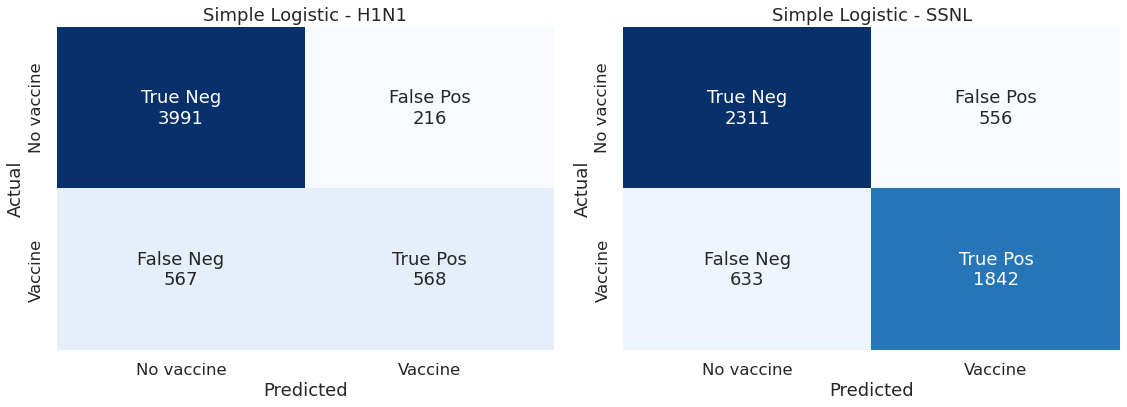

In [489]:
# Baseline Logistic Regression

train_new_model([LogisticRegression(max_iter=1000), LogisticRegression(max_iter=1000)], 'linear', keep_score=True, model_name=['Simple Logistic - H1N1', 'Simple Logistic - SSNL'])

We'll leave this for now without attempting to tune it. Our best results will almost certainly be obtained via more advanced models.

## Naive Bayes

Recall for Untuned Naive Bayes - H1N1:    0.7295154185022027
Recall for Untuned Naive Bayes - SSNL:    0.7684848484848484

Precision for Untuned Naive Bayes - H1N1: 0.37894736842105264
Precision for Untuned Naive Bayes - SSNL: 0.6583592938733126

Accuracy for Untuned Naive Bayes - H1N1:  0.6885061774616249
Accuracy for Untuned Naive Bayes - SSNL:  0.7079745413702733

F1 score for Untuned Naive Bayes - H1N1:  0.4987951807228916
F1 score for Untuned Naive Bayes - SSNL:  0.70917225950783

AUROC for Untuned Naive Bayes - H1N1:     0.7618796656296565
AUROC for Untuned Naive Bayes - SSNL:     0.7826719937427994


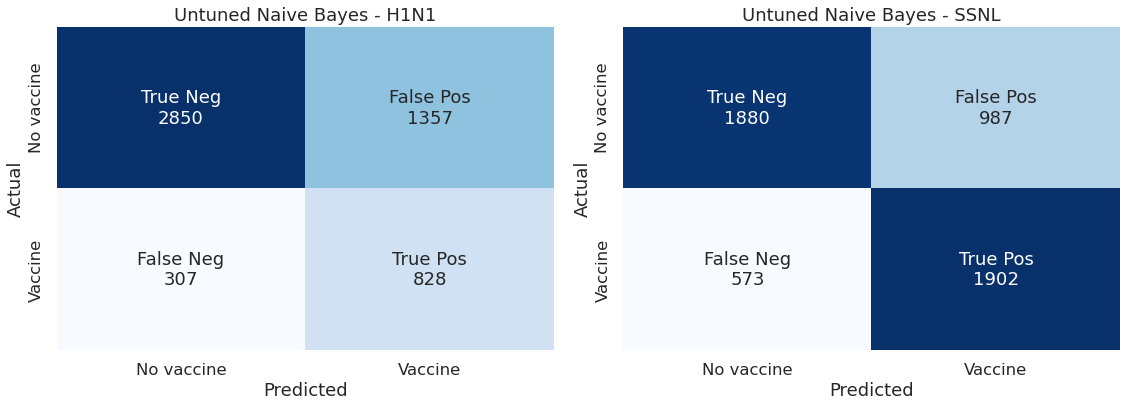

In [150]:
# Untuned Naive Bayes

train_new_model([GaussianNB(), GaussianNB()], 'linear', model_name=['Untuned Naive Bayes - H1N1', 'Untuned Naive Bayes - SSNL'], keep_score=True)

### Grid Searching

In [502]:
gnb = models_dict['Untuned Naive Bayes - H1N1']['estimator']

In [503]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

In [509]:
gs_NB = GridSearchCV(estimator=gnb, 
                 param_grid=params_NB, 
                 cv=3,   
                 verbose=1, 
                 scoring='accuracy')

gs_NB.fit(X_train_linear, y_train_h1n1);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   14.0s finished


In [510]:
gs_NB.best_params_

{'var_smoothing': 1.0}

In [511]:
gs_NB.fit(X_train_linear, y_train_ssnl);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   13.6s finished


In [512]:
gs_NB.best_params_

{'var_smoothing': 1.0}

### And now we'll use these parameters to get all our scores and graphs

Recall for Tuned Naive Bayes - H1N1:    0.5744493392070484
Recall for Tuned Naive Bayes - SSNL:    0.7915151515151515

Precision for Tuned Naive Bayes - H1N1: 0.57243195785777
Precision for Tuned Naive Bayes - SSNL: 0.6941885187810064

Accuracy for Tuned Naive Bayes - H1N1:  0.8184200673904904
Accuracy for Tuned Naive Bayes - SSNL:  0.7418569824035942

F1 score for Tuned Naive Bayes - H1N1:  0.5734388742304309
F1 score for Tuned Naive Bayes - SSNL:  0.7396639607324902

AUROC for Tuned Naive Bayes - H1N1:     0.8285115325935691
AUROC for Tuned Naive Bayes - SSNL:     0.82314445466172


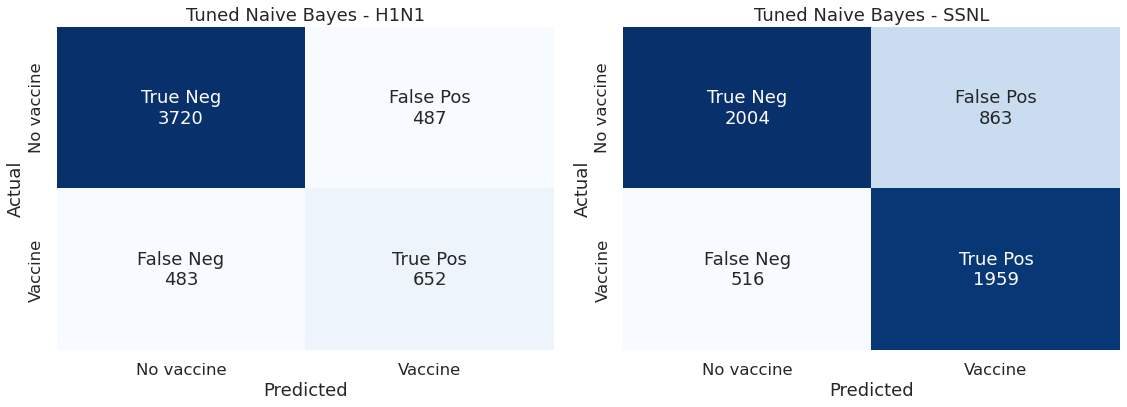

In [151]:
# Tuned Naive Bayes

train_new_model([GaussianNB(var_smoothing=1), GaussianNB(var_smoothing=1)], 'linear', model_name=['Tuned Naive Bayes - H1N1', 'Tuned Naive Bayes - SSNL'], keep_score=True)

And we'll do the same for the rest of the models from here on: train an untuned model, then tune with a grid search.

## Histogram-Based Gradient Boosting

Recall for Untuned HistGradientBoost - H1N1:    0.4995594713656388
Recall for Untuned HistGradientBoost - SSNL:    0.7595959595959596

Precision for Untuned HistGradientBoost - H1N1: 0.7373211963589077
Precision for Untuned HistGradientBoost - SSNL: 0.7701761573125768

Accuracy for Untuned HistGradientBoost - H1N1:  0.8558592287532759
Accuracy for Untuned HistGradientBoost - SSNL:  0.7836016473231

F1 score for Untuned HistGradientBoost - H1N1:  0.5955882352941176
F1 score for Untuned HistGradientBoost - SSNL:  0.7648494711147275

AUROC for Untuned HistGradientBoost - H1N1:     0.8733169701431116
AUROC for Untuned HistGradientBoost - SSNL:     0.8584007497366409


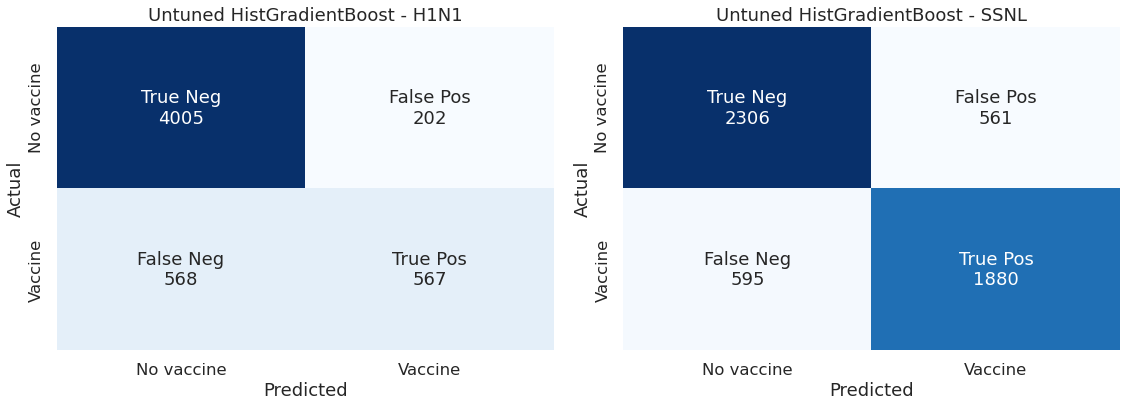

In [152]:
# Untuned HistGradientBoost

train_new_model([HistGradientBoostingClassifier(), HistGradientBoostingClassifier()], 'tree', model_name=['Untuned HistGradientBoost - H1N1', 'Untuned HistGradientBoost - SSNL'], keep_score=True)

### Grid Searching

In [519]:
model_2_h1n1 = models_dict['Untuned HistGradientBoost - H1N1']['estimator']
parameters = {
    "max_iter":[10, 30, 50, 70, 100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [520]:
cv_h1n1 = GridSearchCV(model_2_h1n1,parameters,cv=5)
cv_h1n1.fit(X_train_tree, y_train_h1n1)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_iter': [10, 30, 50, 70, 100]})

In [521]:
cv_h1n1.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 100}

In [525]:
cv_h1n1.fit(X_train_tree, y_train_ssnl)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_iter': [10, 30, 50, 70, 100]})

In [526]:
cv_h1n1.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 100}

Recall for Tuned HistGradientBoost - H1N1:    0.5215859030837005
Recall for Tuned HistGradientBoost - SSNL:    0.7587878787878788

Precision for Tuned HistGradientBoost - H1N1: 0.736318407960199
Precision for Tuned HistGradientBoost - SSNL: 0.7665306122448979

Accuracy for Tuned HistGradientBoost - H1N1:  0.8586671658554849
Accuracy for Tuned HistGradientBoost - SSNL:  0.7811681018345189

F1 score for Tuned HistGradientBoost - H1N1:  0.6106240330067044
F1 score for Tuned HistGradientBoost - SSNL:  0.7626395939086295

AUROC for Tuned HistGradientBoost - H1N1:     0.8726054436229108
AUROC for Tuned HistGradientBoost - SSNL:     0.8580014304185911


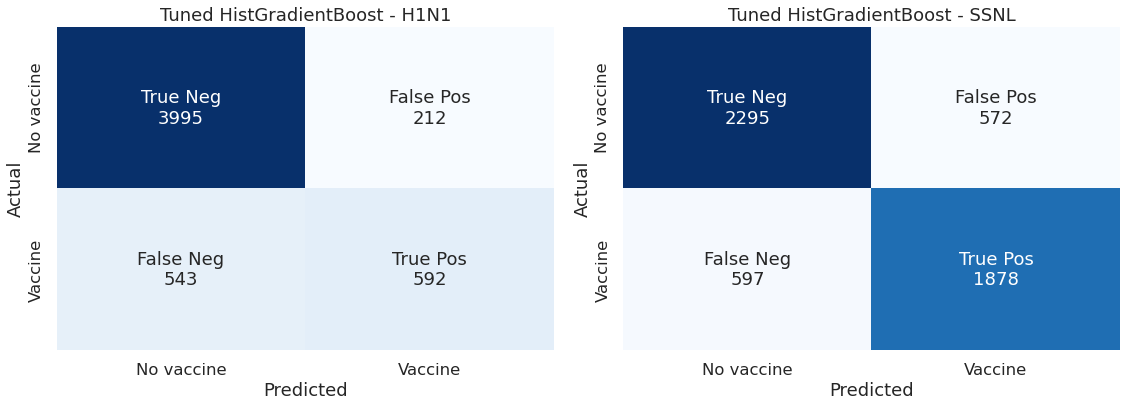

In [524]:
# Tuned HistGradientBoosting

train_new_model([HistGradientBoostingClassifier(learning_rate=0.1, max_depth=9, max_iter=100, random_state=random_state), HistGradientBoostingClassifier(learning_rate=0.1, max_depth=9, max_iter=100, random_state=random_state)], 'tree', model_name=['Tuned HistGradientBoost - H1N1', 'Tuned HistGradientBoost - SSNL'], keep_score=True)

## Random Forest

Recall for Untuned Random Forest - H1N1:    0.4290748898678414
Recall for Untuned Random Forest - SSNL:    0.7373737373737373

Precision for Untuned Random Forest - H1N1: 0.773015873015873
Precision for Untuned Random Forest - SSNL: 0.7635983263598326

Accuracy for Untuned Random Forest - H1N1:  0.8519281168101834
Accuracy for Untuned Random Forest - SSNL:  0.7725570947210783

F1 score for Untuned Random Forest - H1N1:  0.5518413597733711
F1 score for Untuned Random Forest - SSNL:  0.750256937307297

AUROC for Untuned Random Forest - H1N1:     0.862308361666993
AUROC for Untuned Random Forest - SSNL:     0.8473333967509064


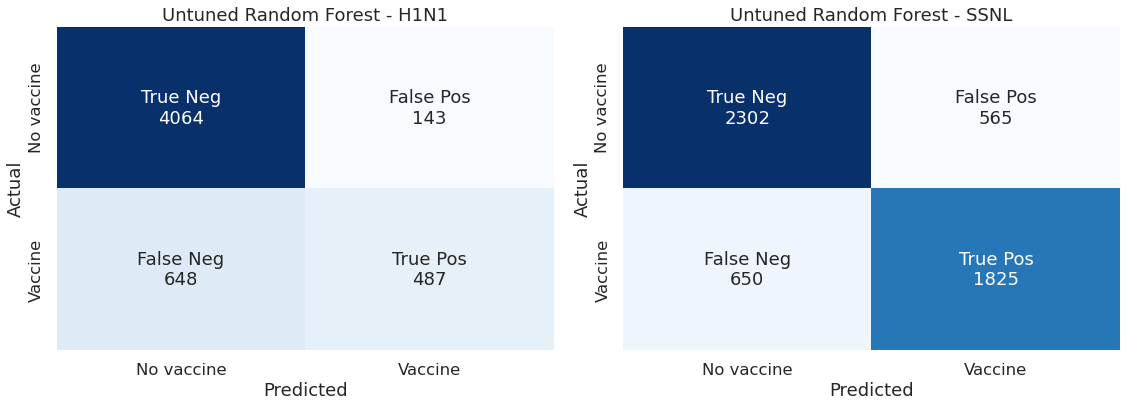

In [318]:
# Untuned Random Forest

train_new_model([RandomForestClassifier(random_state=random_state), RandomForestClassifier(random_state=random_state)], 'tree', model_name=['Untuned Random Forest - H1N1', 'Untuned Random Forest - SSNL'], keep_score=True)

### Grid Searching

We've actually done several grid searches for this model, narrowing things down as we've gone, but we'll just show the final one in order to not waste space with a bunch of repetitive code.

In [513]:
forest1 = models_dict['Untuned Random Forest - H1N1']['estimator']

In [514]:
dt_param_grid7 = {
    'criterion': ['gini'],
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'max_leaf_nodes': [30, 40, 50],
    'n_estimators': [100]
}

In [515]:
# Instantiate GridSearchCV
dt_grid_search7 = GridSearchCV(forest1, dt_param_grid7, cv=3, return_train_score=True)

# Fit to the data --  H1N1
dt_grid_search7.fit(X_train_tree, y_train_h1n1)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1232022),
             param_grid={'criterion': ['gini'], 'max_depth': [20],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [30, 40, 50],
                         'min_samples_leaf': [2], 'min_samples_split': [10],
                         'n_estimators': [100]},
             return_train_score=True)

In [516]:
dt_grid_search7.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [517]:
dt_grid_search7.fit(X_train_tree, y_train_ssnl)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1232022),
             param_grid={'criterion': ['gini'], 'max_depth': [20],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [30, 40, 50],
                         'min_samples_leaf': [2], 'min_samples_split': [10],
                         'n_estimators': [100]},
             return_train_score=True)

In [518]:
dt_grid_search7.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

Recall for Tuned Random Forest - H1N1:    0.26519823788546254
Recall for Tuned Random Forest - SSNL:    0.7014141414141414

Precision for Tuned Random Forest - H1N1: 0.8135135135135135
Precision for Tuned Random Forest - SSNL: 0.766107678729038

Accuracy for Tuned Random Forest - H1N1:  0.8309621864470236
Accuracy for Tuned Random Forest - SSNL:  0.7624485211531262

F1 score for Tuned Random Forest - H1N1:  0.39999999999999997
F1 score for Tuned Random Forest - SSNL:  0.7323349504323983

AUROC for Tuned Random Forest - H1N1:     0.8525977786131567
AUROC for Tuned Random Forest - SSNL:     0.8410986037564343


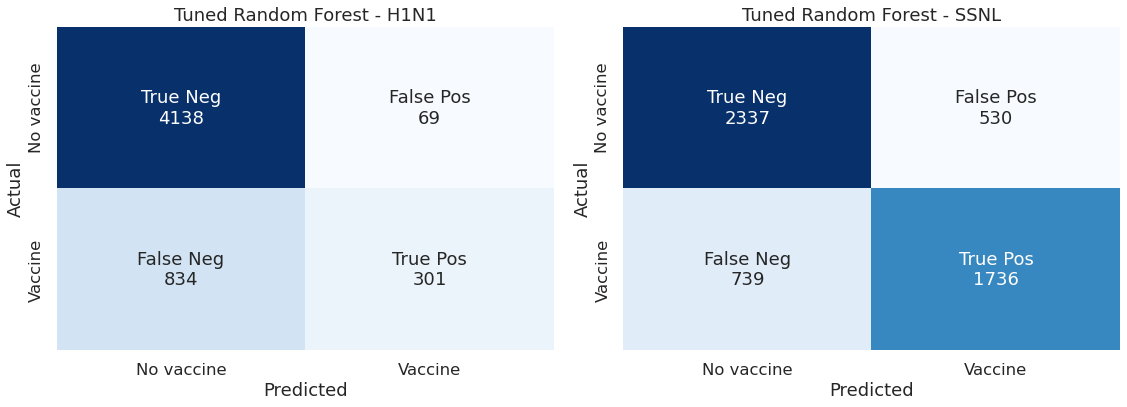

In [455]:
# Tuned Random Forest

train_new_model([RandomForestClassifier(criterion='gini', max_depth=20, max_leaf_nodes=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=random_state), RandomForestClassifier(criterion='gini', max_depth=20, max_leaf_nodes=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=random_state)], 'tree', model_name=['Tuned Random Forest - H1N1', 'Tuned Random Forest - SSNL'], keep_score=True)

## Support Vector Machine

Recall for Untuned SVC - H1N1:    0.45374449339207046
Recall for Untuned SVC - SSNL:    0.7450505050505051

Precision for Untuned SVC - H1N1: 0.7756024096385542
Precision for Untuned SVC - SSNL: 0.7689741451209341

Accuracy for Untuned SVC - H1N1:  0.8560464245600898
Accuracy for Untuned SVC - SSNL:  0.778172968925496

F1 score for Untuned SVC - H1N1:  0.5725403001667593
F1 score for Untuned SVC - SSNL:  0.7568233121280525

AUROC for Untuned SVC - H1N1:     0.8602382854671625
AUROC for Untuned SVC - SSNL:     0.8547654430598274


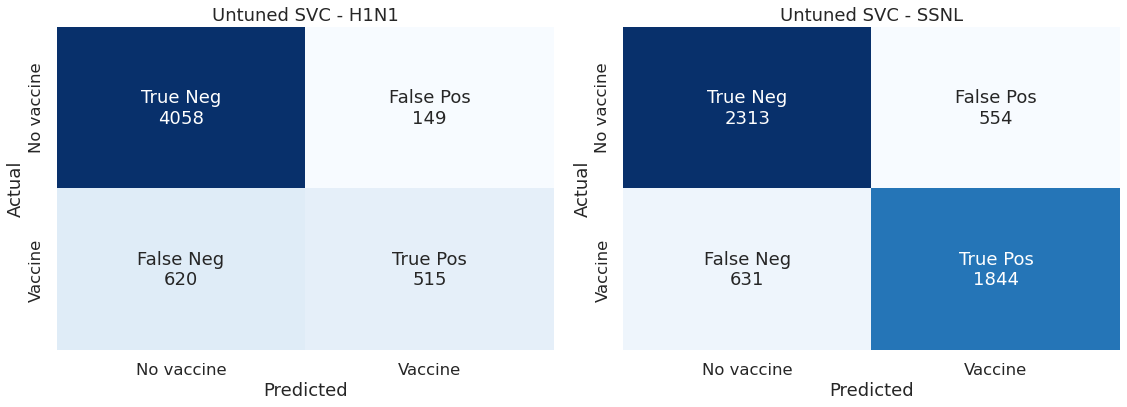

In [156]:
# Untuned SVC

train_new_model([SVC(probability=True), SVC(probability=True)], 'linear', model_name=['Untuned SVC - H1N1', 'Untuned SVC - SSNL'], keep_score=True)

### Grid Searching

In [560]:
svm_1_h1n1 = models_dict['Untuned SVC - H1N1']['estimator']

In [561]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

# This will take a while to run, so we've set n_jobs to -1. Don't plan on using your computer for some time if you run this.
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, n_jobs=-1)

grid.fit(X_train_linear, y_train_ssnl);

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 94.8min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 245.3min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 402.1min finished


In [562]:
grid.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [564]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']}
 
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, n_jobs=-1)

grid.fit(X_train_linear, y_train_h1n1);

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 145.3min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 214.7min finished


In [565]:
grid.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Recall for Tuned SVC - H1N1:    0.47048458149779737
Recall for Tuned SVC - SSNL:    0.7434343434343434

Precision for Tuned SVC - H1N1: 0.7650429799426934
Precision for Tuned SVC - SSNL: 0.777027027027027

Accuracy for Tuned SVC - H1N1:  0.8567952077873455
Accuracy for Tuned SVC - SSNL:  0.7822912766754024

F1 score for Tuned SVC - H1N1:  0.5826513911620295
F1 score for Tuned SVC - SSNL:  0.7598595911625025

AUROC for Tuned SVC - H1N1:     0.8556106928980334
AUROC for Tuned SVC - SSNL:     0.8575641310207058


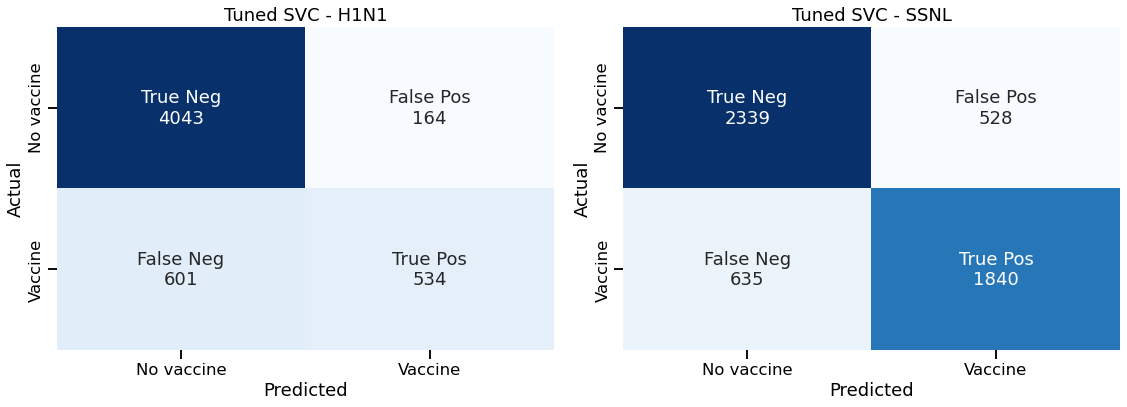

In [35]:
# Tuned SVC

train_new_model([SVC(probability = True, kernel='rbf', C=10, gamma=0.01), SVC(probability = True, kernel='rbf', C=100, gamma=0.001)], 'linear', model_name=['Tuned SVC - H1N1', 'Tuned SVC - SSNL'], keep_score=True)

# Exploring our top performers
### with permutation importance and partial dependence plots

Here we'll take a look at the specifics of our best models. Which features had the most effect on the model's ability to correctly categorize the data?

### Random Forest (H1N1)

In [457]:
rf = RandomForestClassifier(criterion='gini', max_depth=20, max_leaf_nodes=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=random_state)
rf.fit(X_train_tree, y_train_h1n1)

RandomForestClassifier(max_depth=20, max_leaf_nodes=50, min_samples_leaf=2,
                       min_samples_split=10, random_state=1232022)

In [458]:
perm = PermutationImportance(rf, random_state=random_state).fit(X_test_tree, y_test_h1n1)
eli5.show_weights(perm, feature_names = X_test_tree.columns.tolist())

Weight,Feature
0.0216 ± 0.0025,doctor_recc_h1n1
0.0175 ± 0.0033,health_insurance
0.0171 ± 0.0047,opinion_h1n1_risk
0.0092 ± 0.0012,opinion_h1n1_vacc_effective
0.0081 ± 0.0017,opinion_seas_risk
0.0061 ± 0.0014,doctor_recc_seasonal
0.0039 ± 0.0021,opinion_seas_vacc_effective
0.0021 ± 0.0008,health_worker
0.0012 ± 0.0010,h1n1_knowledge
0.0009 ± 0.0010,x10_fcxhlnwr


It looks like a doctor's recommendation, whether or not the individual had health insurance, and their opinion of the risk of H1N1 played the largest roles in the model's ability to determine a person's vaccination status. Let's graph those categories in a partial dependence plot to see the relationship of each option in each category to the ability of the model to correctly make predictions.

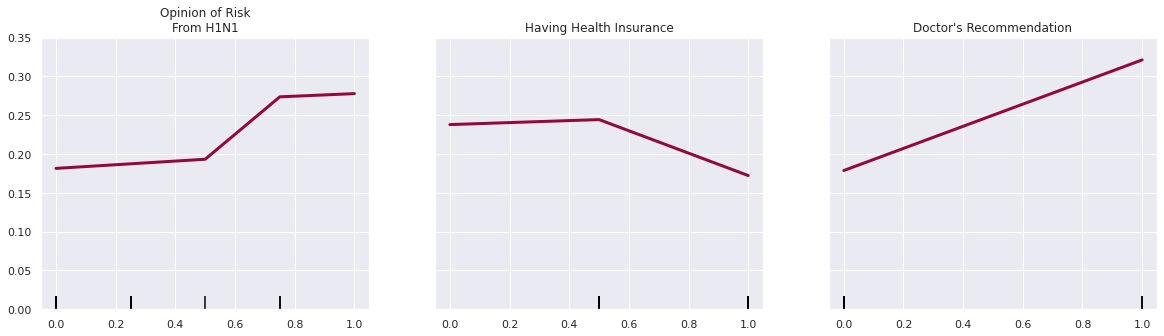

In [466]:
line_style = {'color':'#94093a', 'lw':3}

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 5), ncols=3)

plot_partial_dependence(rf, X_train_tree,['opinion_h1n1_risk', 'health_insurance', 'doctor_recc_h1n1'], line_kw=line_style, ax=(ax1, ax2, ax3))

sns.set_style('darkgrid')
sns.set_context("notebook")

ax1.set(ylim=(0,.35))
ax2.set(ylim=(0,.35))
ax3.set(ylim=(0,.35))

ax1.set_title('Opinion of Risk\nFrom H1N1')
ax2.set_title('Having Health Insurance')
ax3.set_title("Doctor's Recommendation")

ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax3.set_xlabel(None)

ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax3.set_ylabel(None)

ax2.set_yticklabels([])
ax3.set_yticklabels([]);

#fig.savefig('graphs/partial_dependence_rf', dpi=300, transparent=False, bbox_inches='tight', pad_inches=.5);

So for opinion of risk from H1N1 and a doctor's recommendation, the model performs better as the values in those categories increase, meaning that, for instance, if the model knows that your doctor recommended the vaccine, the model is much more certain in making its prediction than if your doctor hasn't recommended it. In this case, we can infer that a doctor's recommendation is likely to increase the chances of someone getting the vaccine, and likewise higher perceived risk from H1N1 likely also indicates higher likelihood of receiving the vaccine.

(Note: health insurance uses a dummy value for "unknown," which is to the right of the other two values, meaning the drop actually shows that the model gleans a decently equivalent amount of information from whether or not someone has health insurance, but struggles when it doesn't have this information.)

### Support Vector Machine (Seasonal Flu)

In [38]:
svm_1_ssnl = SVC(probability = True, kernel='rbf', C=100, gamma=0.001)

svm_1_ssnl.fit(X_train_linear, y_train_ssnl)

SVC(C=100, gamma=0.001, probability=True)

In [39]:
perm = PermutationImportance(svm_1_ssnl, random_state=random_state).fit(X_test_linear, y_test_ssnl)
eli5.show_weights(perm, feature_names = X_test_linear.columns.tolist())

Weight,Feature
0.0346 ± 0.0036,x18_5.0
0.0214 ± 0.0070,x19_1.0
0.0138 ± 0.0092,x21_4
0.0112 ± 0.0032,x10_0.0
0.0090 ± 0.0060,x10_1.0
0.0090 ± 0.0023,x20_1.0
0.0080 ± 0.0041,x19_5.0
0.0057 ± 0.0018,x21_0
0.0042 ± 0.0040,x14_1.0
0.0038 ± 0.0038,x19_4.0


So this partial dependence plot is slightly difficult to read, because the data it was run on was one-hot encoded. Luckily a lot of our categories are binary to begin with, so it's not as confusing as it looks. Column 18 is opinion on the effectiveness of the seasonal flu vaccine (on a 1-5 scale), column 19 is opinion of risk from seasonal flu (also on a 1-5 scale), and column 21 is age group. Since they are one-hot encoded, each of the three entries only represent a single choice in their respective categories, so for column 18, it's top spot on the permutation importance is only for those who ranked a 5 on vaccine effectiveness opinion, meaning if a person thought the vaccine was very effective, the model was more likely to correctly predict them. Column 19 is similar but in reverse, that is, if a person thought the risk from seasonal flu is very low (an opinion of 1), the model had a harder time predicting them than those who responded differently (illustrated by the negative slope in the graph below). Column 21 is those in the 65+ age category, and since the slope is positive, being 65+ makes for easier prediction.

It's also worth noting that column 10, which is in the fourth spot on this table corresponds to doctor recommendation, which showed up in our top three in the previous model. If a model knows whether or not your doctor has made a recommendation, it has an easier time making a prediction. Given that this almost certainly corresponds to a positive correlation, we will be recommending to health officials to talk to their patients about receiving their vaccines. 

It's also worth noting that between the two models, three of each of their top four are shared in common.

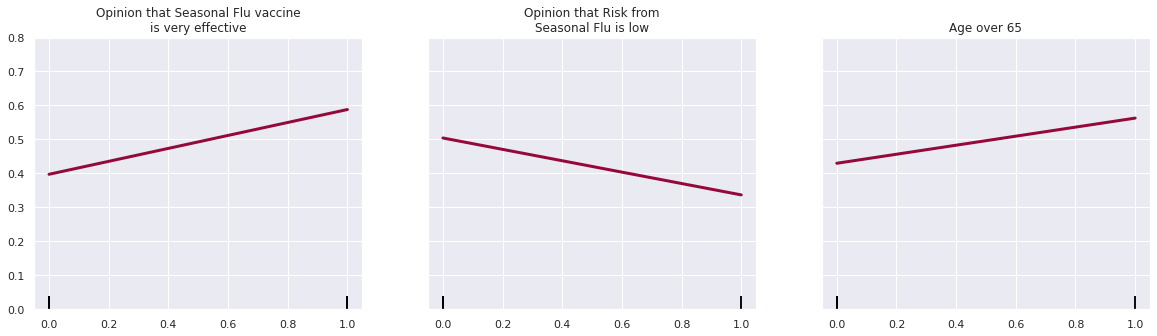

In [44]:
line_style = {'color':'#94093a', 'lw':3}

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 5), ncols=3)

plot_partial_dependence(svm_1_ssnl, X_test_linear,['x18_5.0', 'x19_1.0', 'x21_4'], line_kw=line_style, ax=(ax1, ax2, ax3))

sns.set_style('darkgrid')
sns.set_context('notebook')

ax1.set(ylim=(0,.8))
ax2.set(ylim=(0,.8))
ax3.set(ylim=(0,.8))

ax1.set_title('Opinion that Seasonal Flu vaccine\nis very effective')
ax2.set_title('Opinion that Risk from\nSeasonal Flu is low')
ax3.set_title('Age over 65')

ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax3.set_xlabel(None)

ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax3.set_ylabel(None)

ax2.set_yticklabels([])
ax3.set_yticklabels([]);

#fig.savefig('graphs/partial_dependence_sv', dpi=300, transparent=False, bbox_inches='tight', pad_inches=.5);

# Let's talk demographics

When looking at the difference in vaccinations rates between the seasonal flu and H1N1 vaccines, we noted some groups who were relatively more likely to get the seasonal flu vaccine than the H1N1 vaccine. Within the race category, the largest relative percent decrease between those who received the seasonal flu vaccine and those who received the H1N1 vaccine was within the black category–57%. The white category was not too far beyond at 55%. For the Hispanic category, the difference was 38%. The “other/multiple” category also had a large percent difference (57%), but without a better understanding of what this category includes, it’s hard to make recommendations based on it.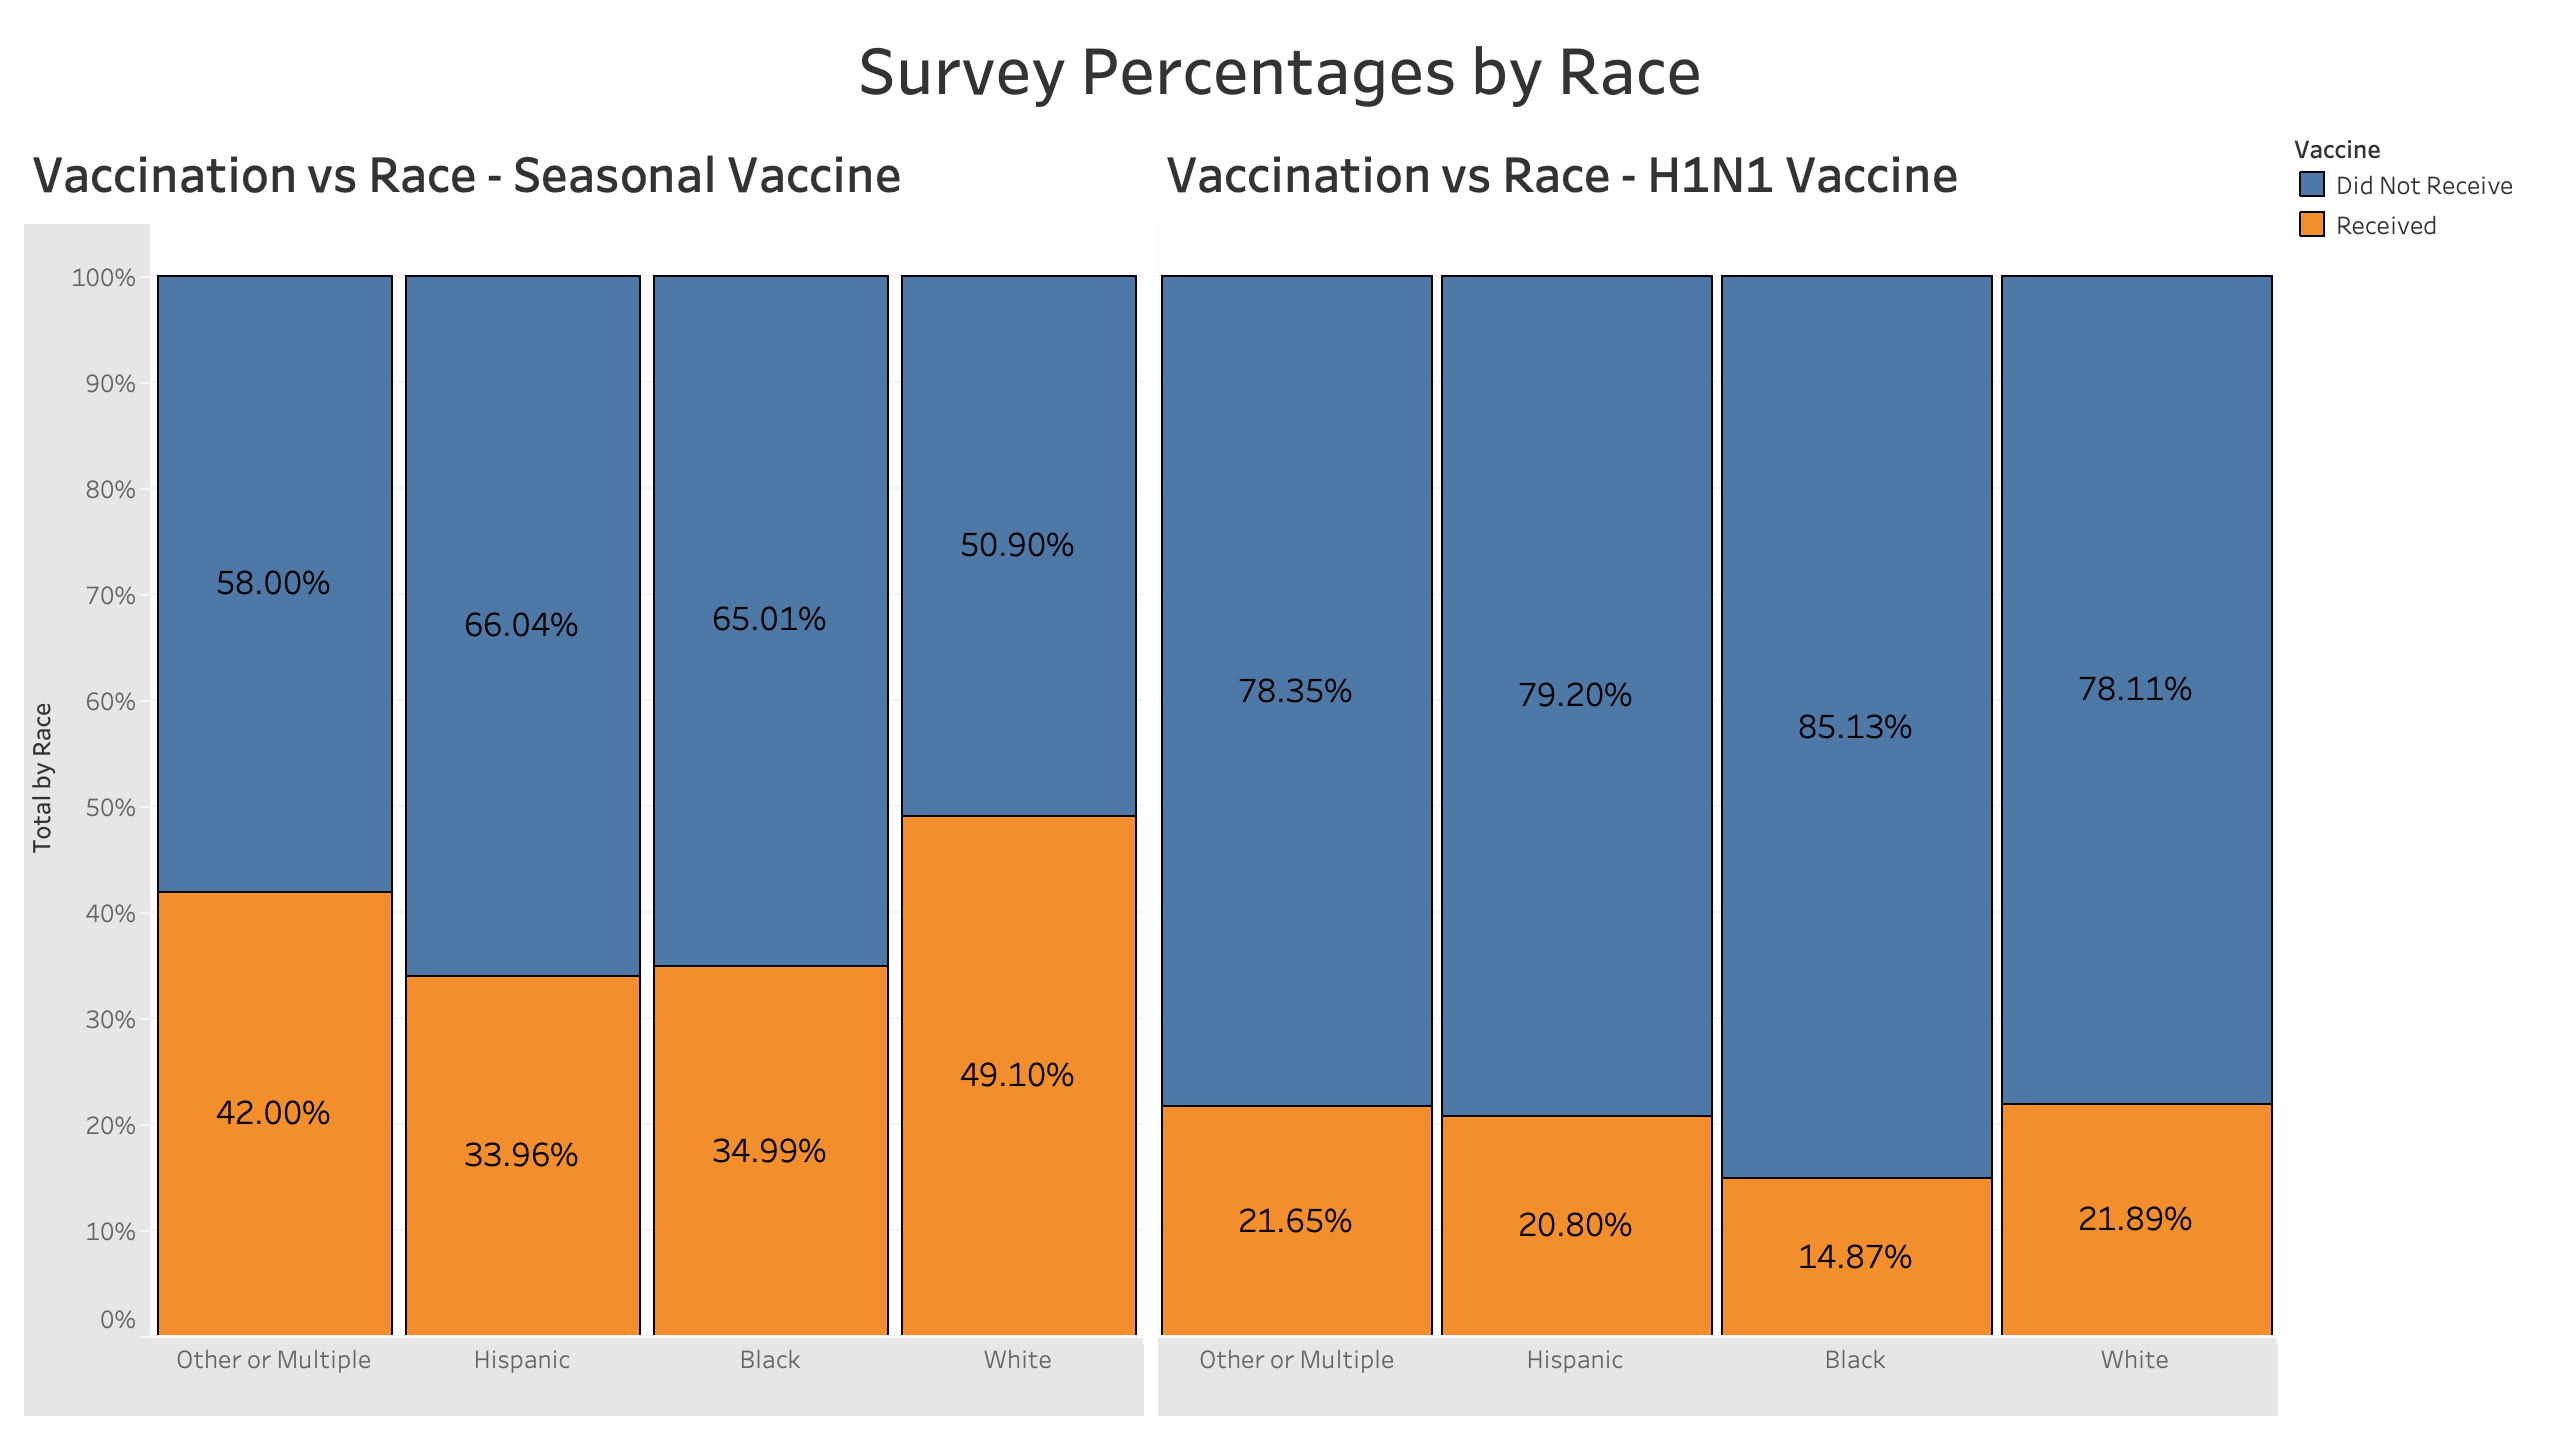

For marital status, unmarried individuals had a slightly higher relative percent decrease than married couples (56% to 53% respectively).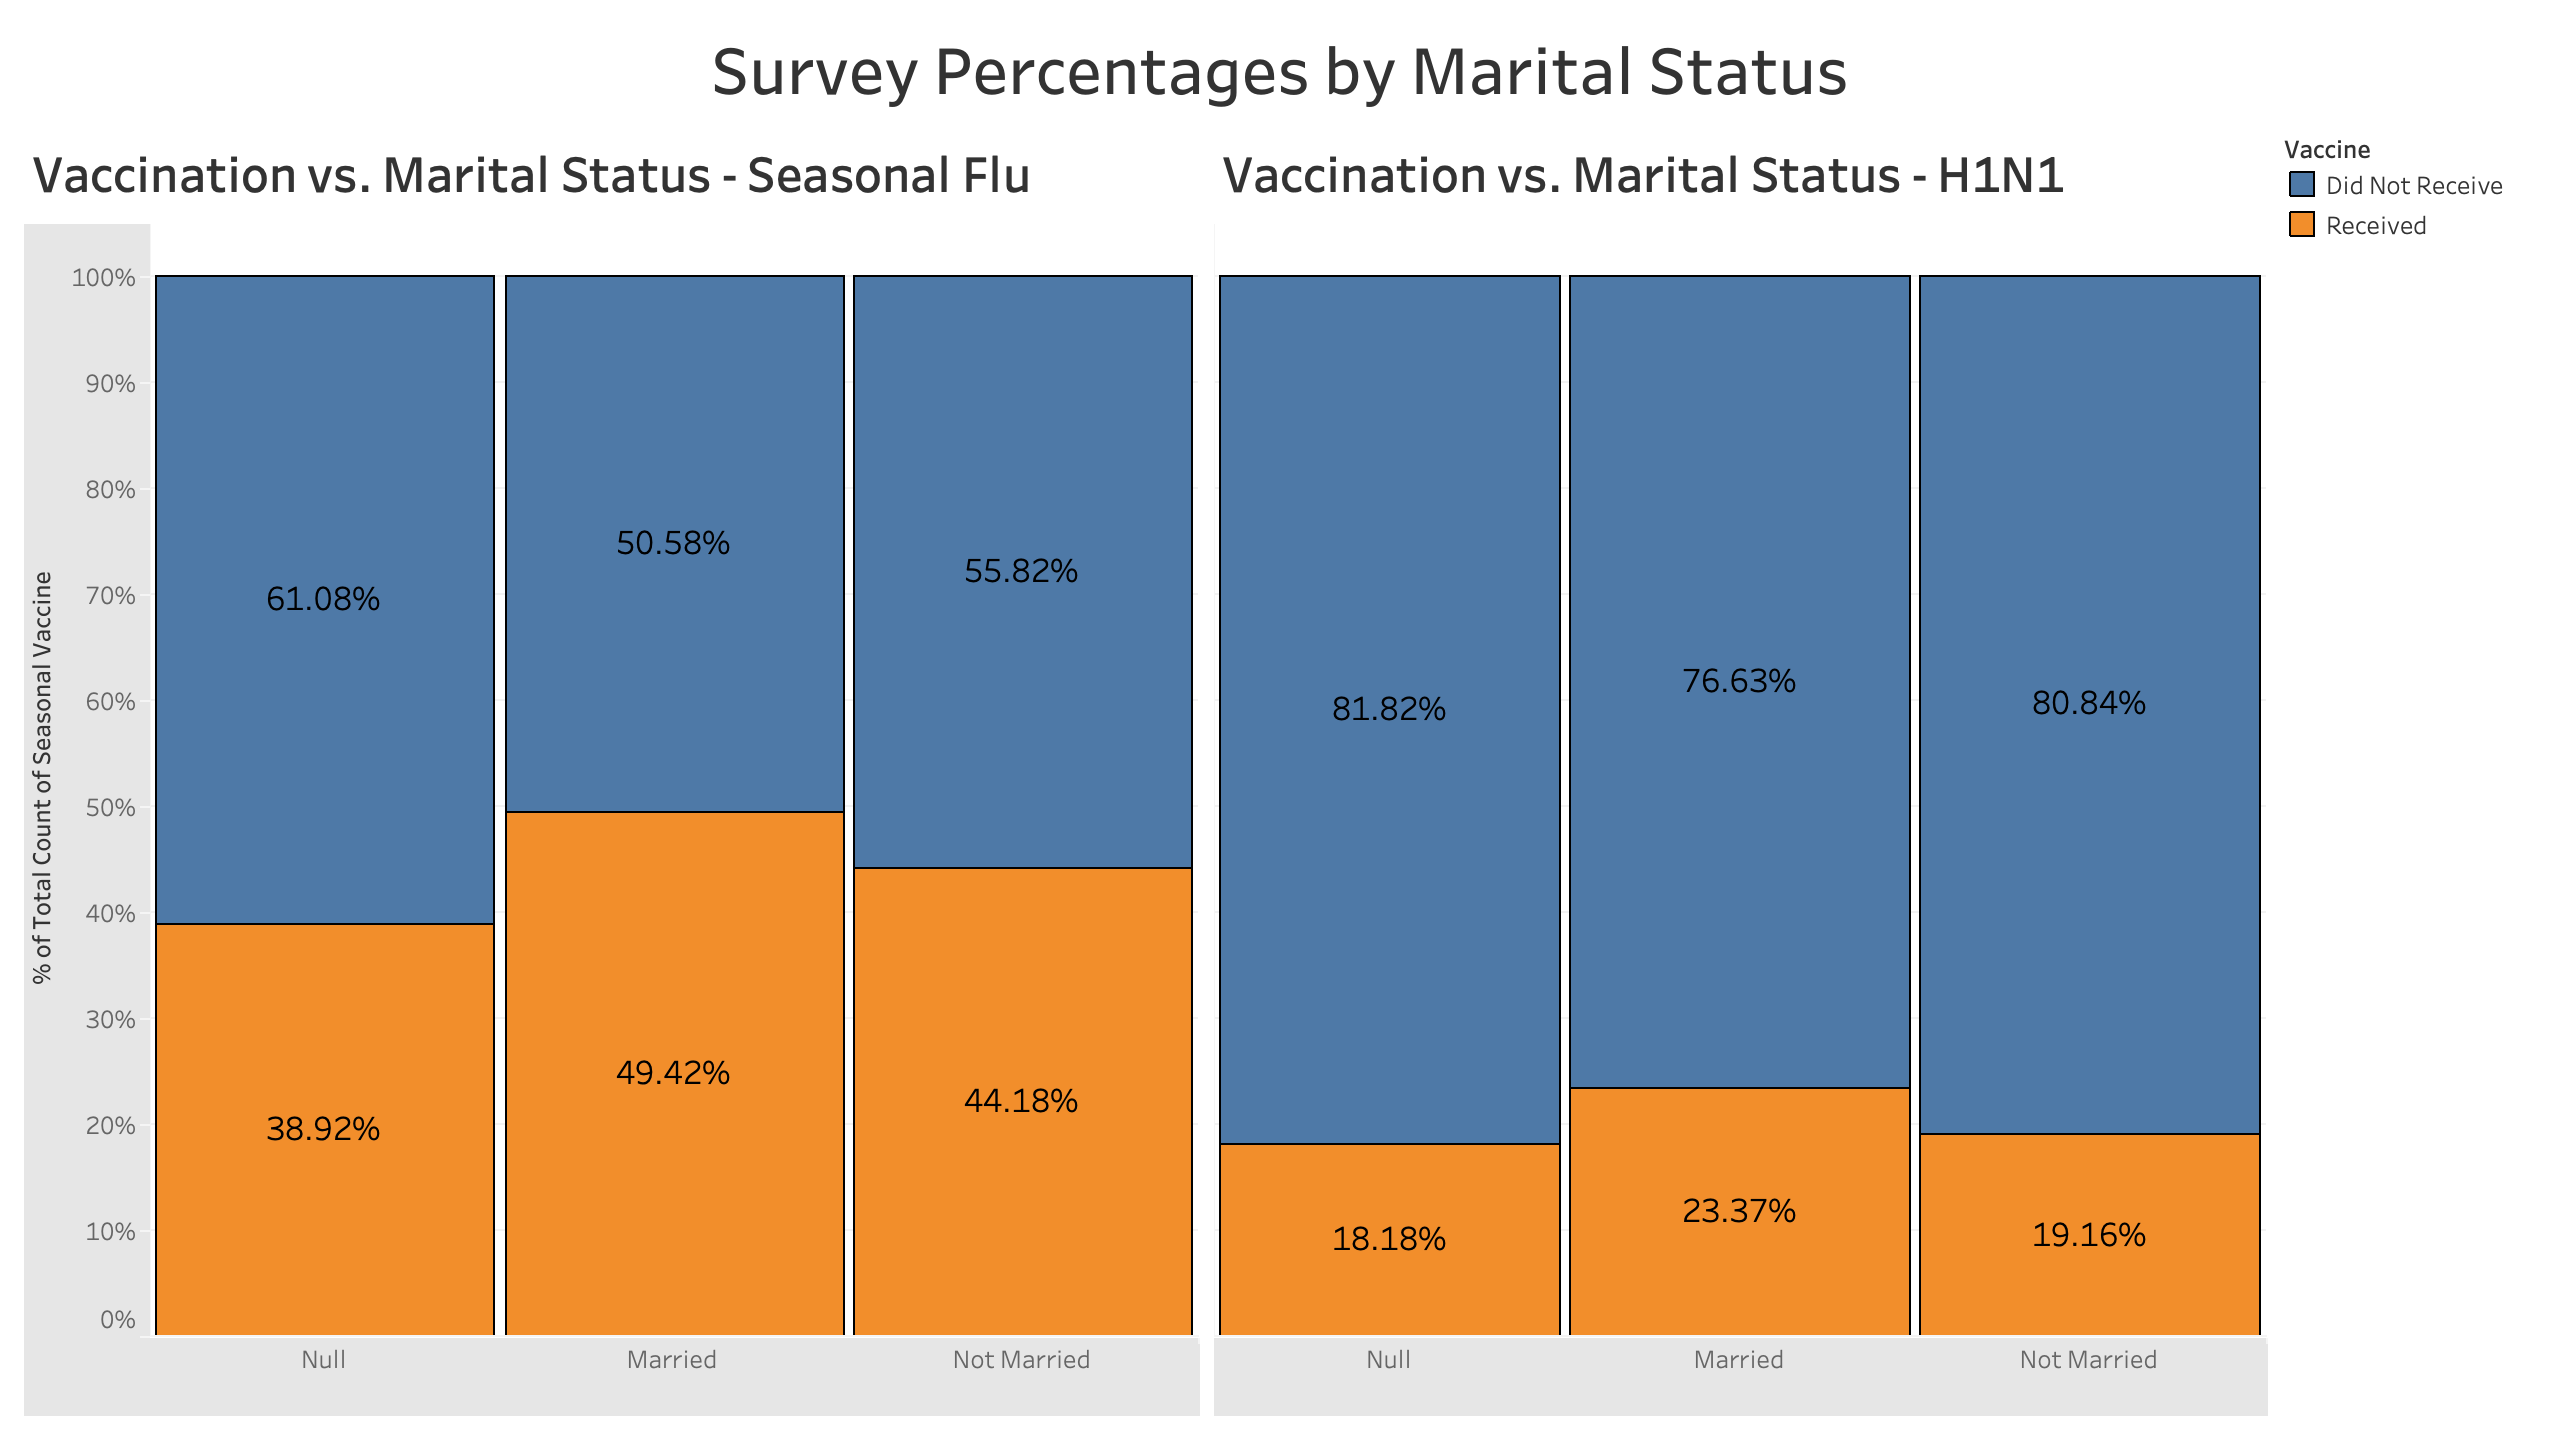

With regards to income brackets, the highest percent decrease in those who got the seasonal flu vaccine versus those getting the H1N1 vaccine can be seen in those who earn more than the poverty level but less than \\$75,000 (58% decrease). This is followed by those who make more than \\$75,000/year (50%) and lastly by those living in poverty (47%).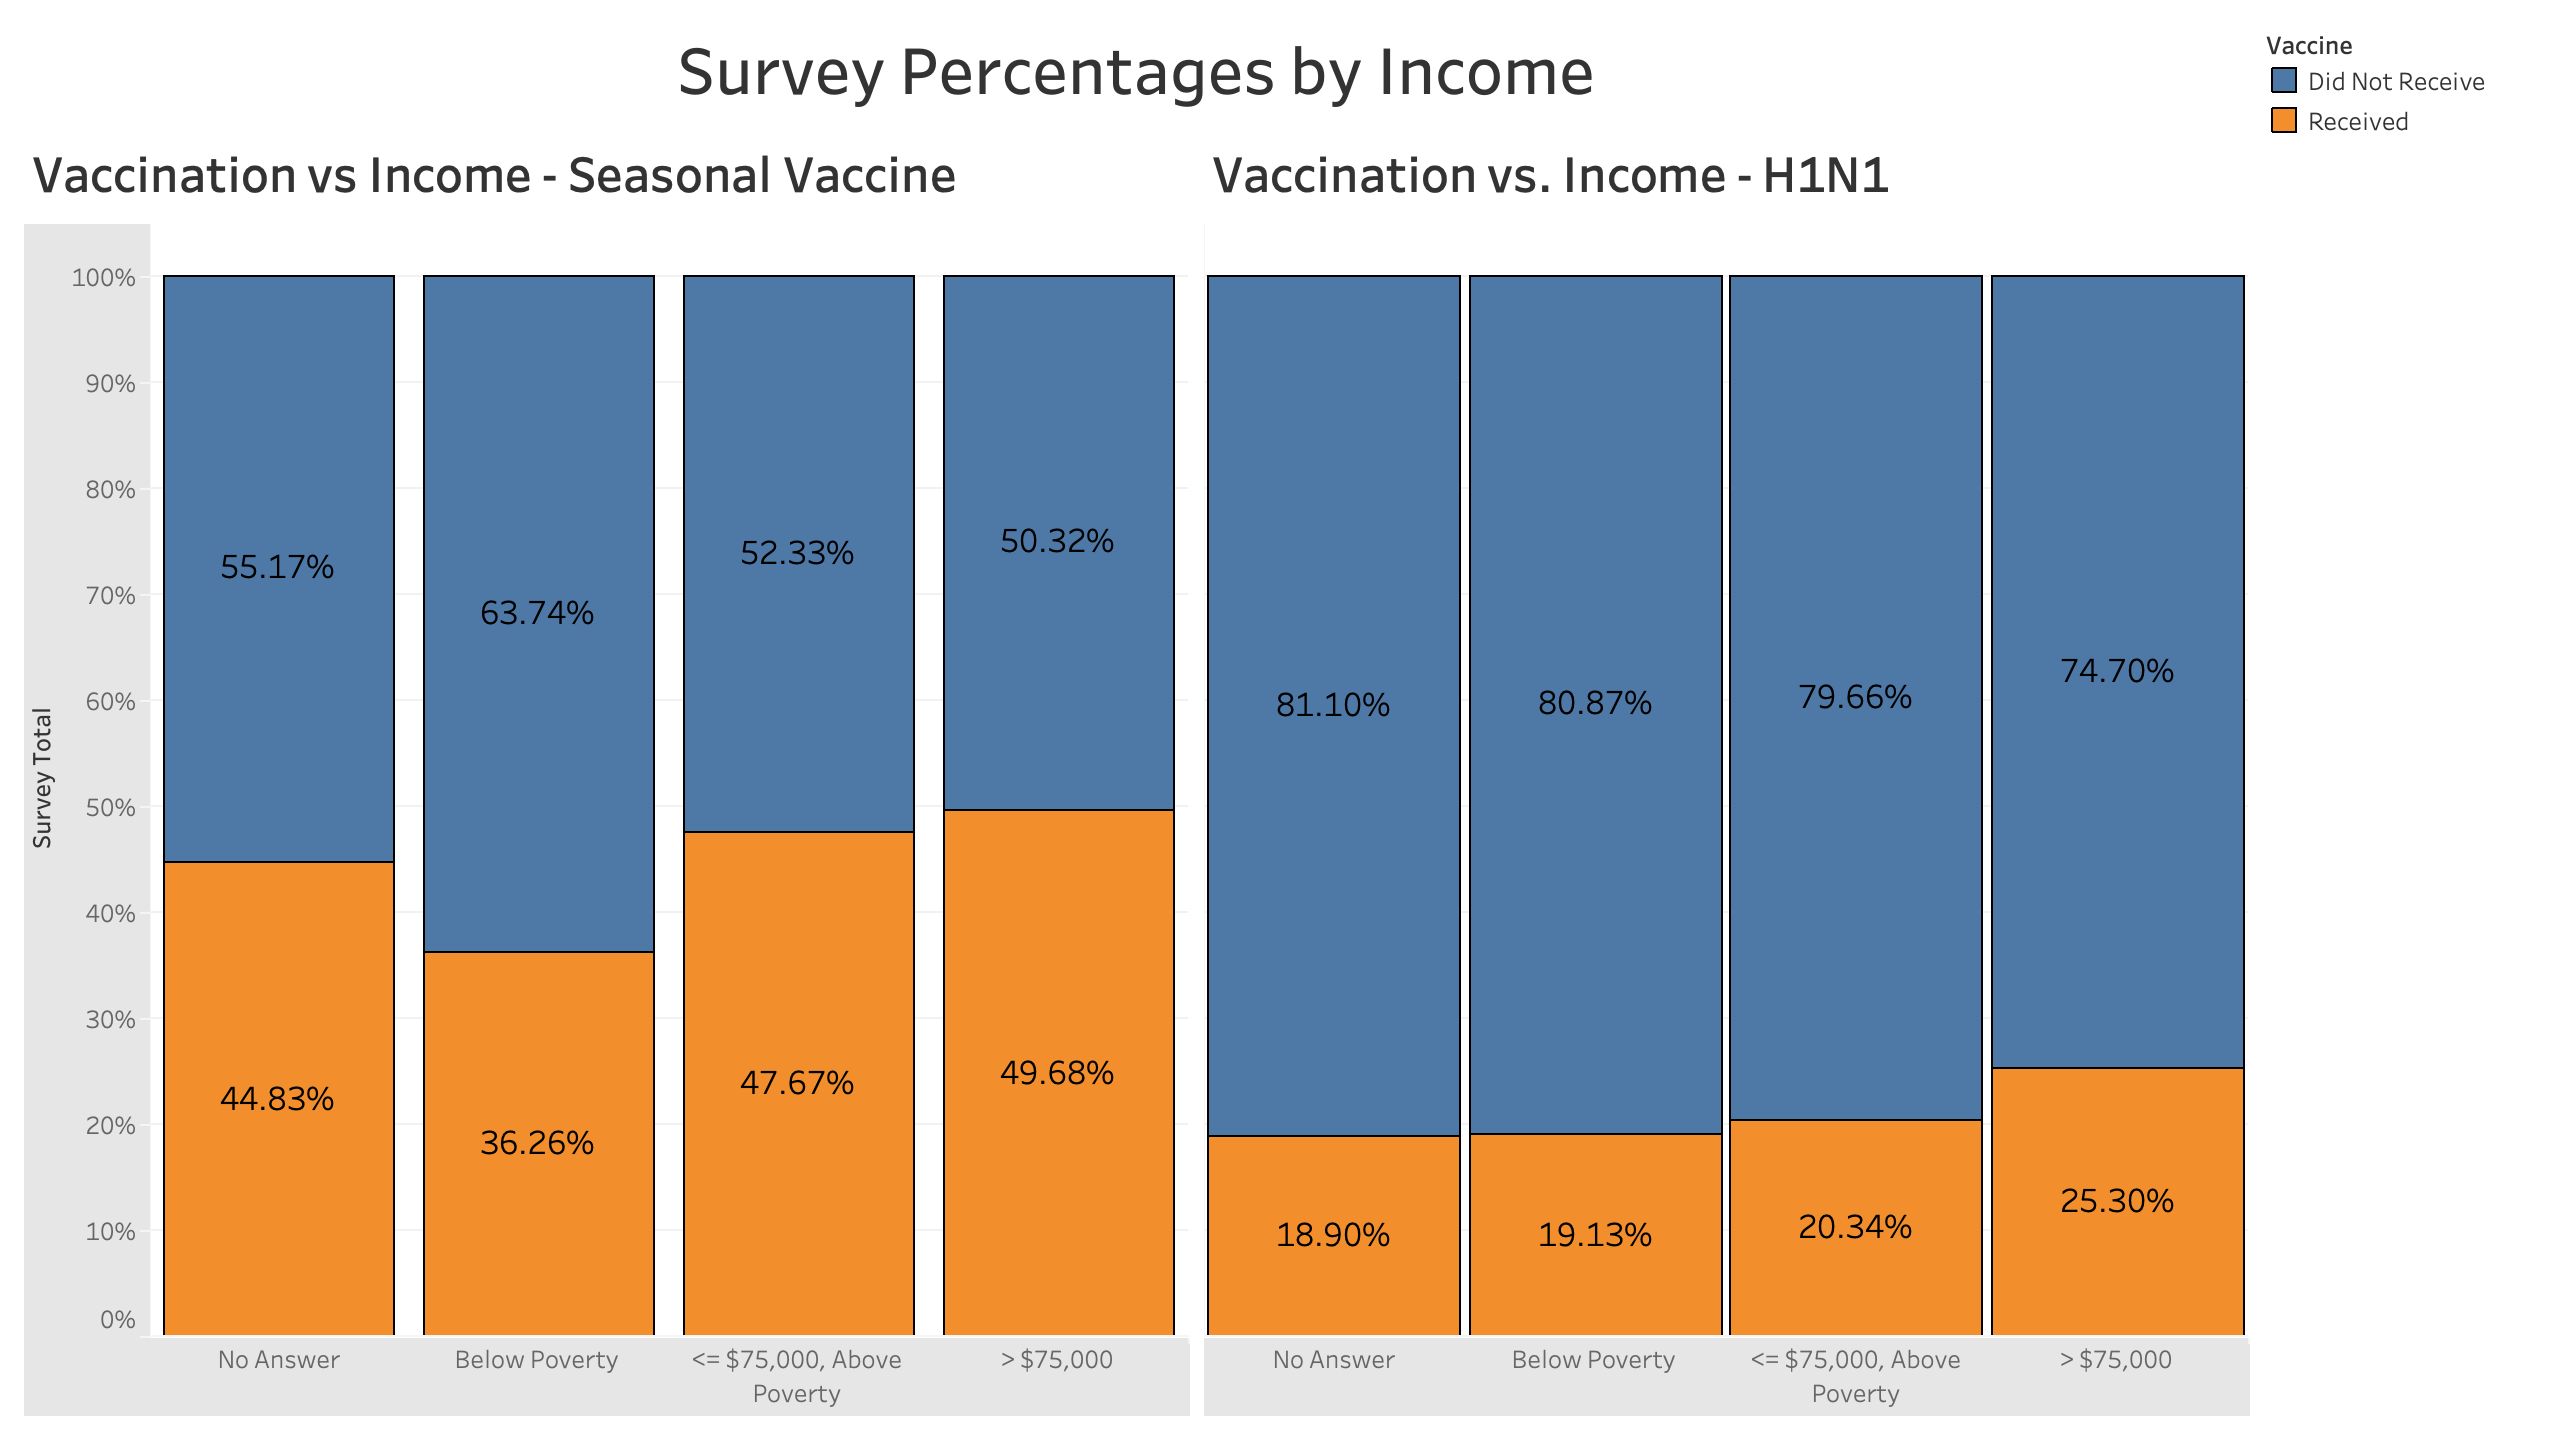

Age groups exhibited the single largest percent decrease between the seasonal and H1N1 vaccines, with those aged 65 and older topping the list at 67%. Those between 55-64 and 45-54 both deceased by 52%; those 35-44 decreased by 47%; and those 18-34 by 32%.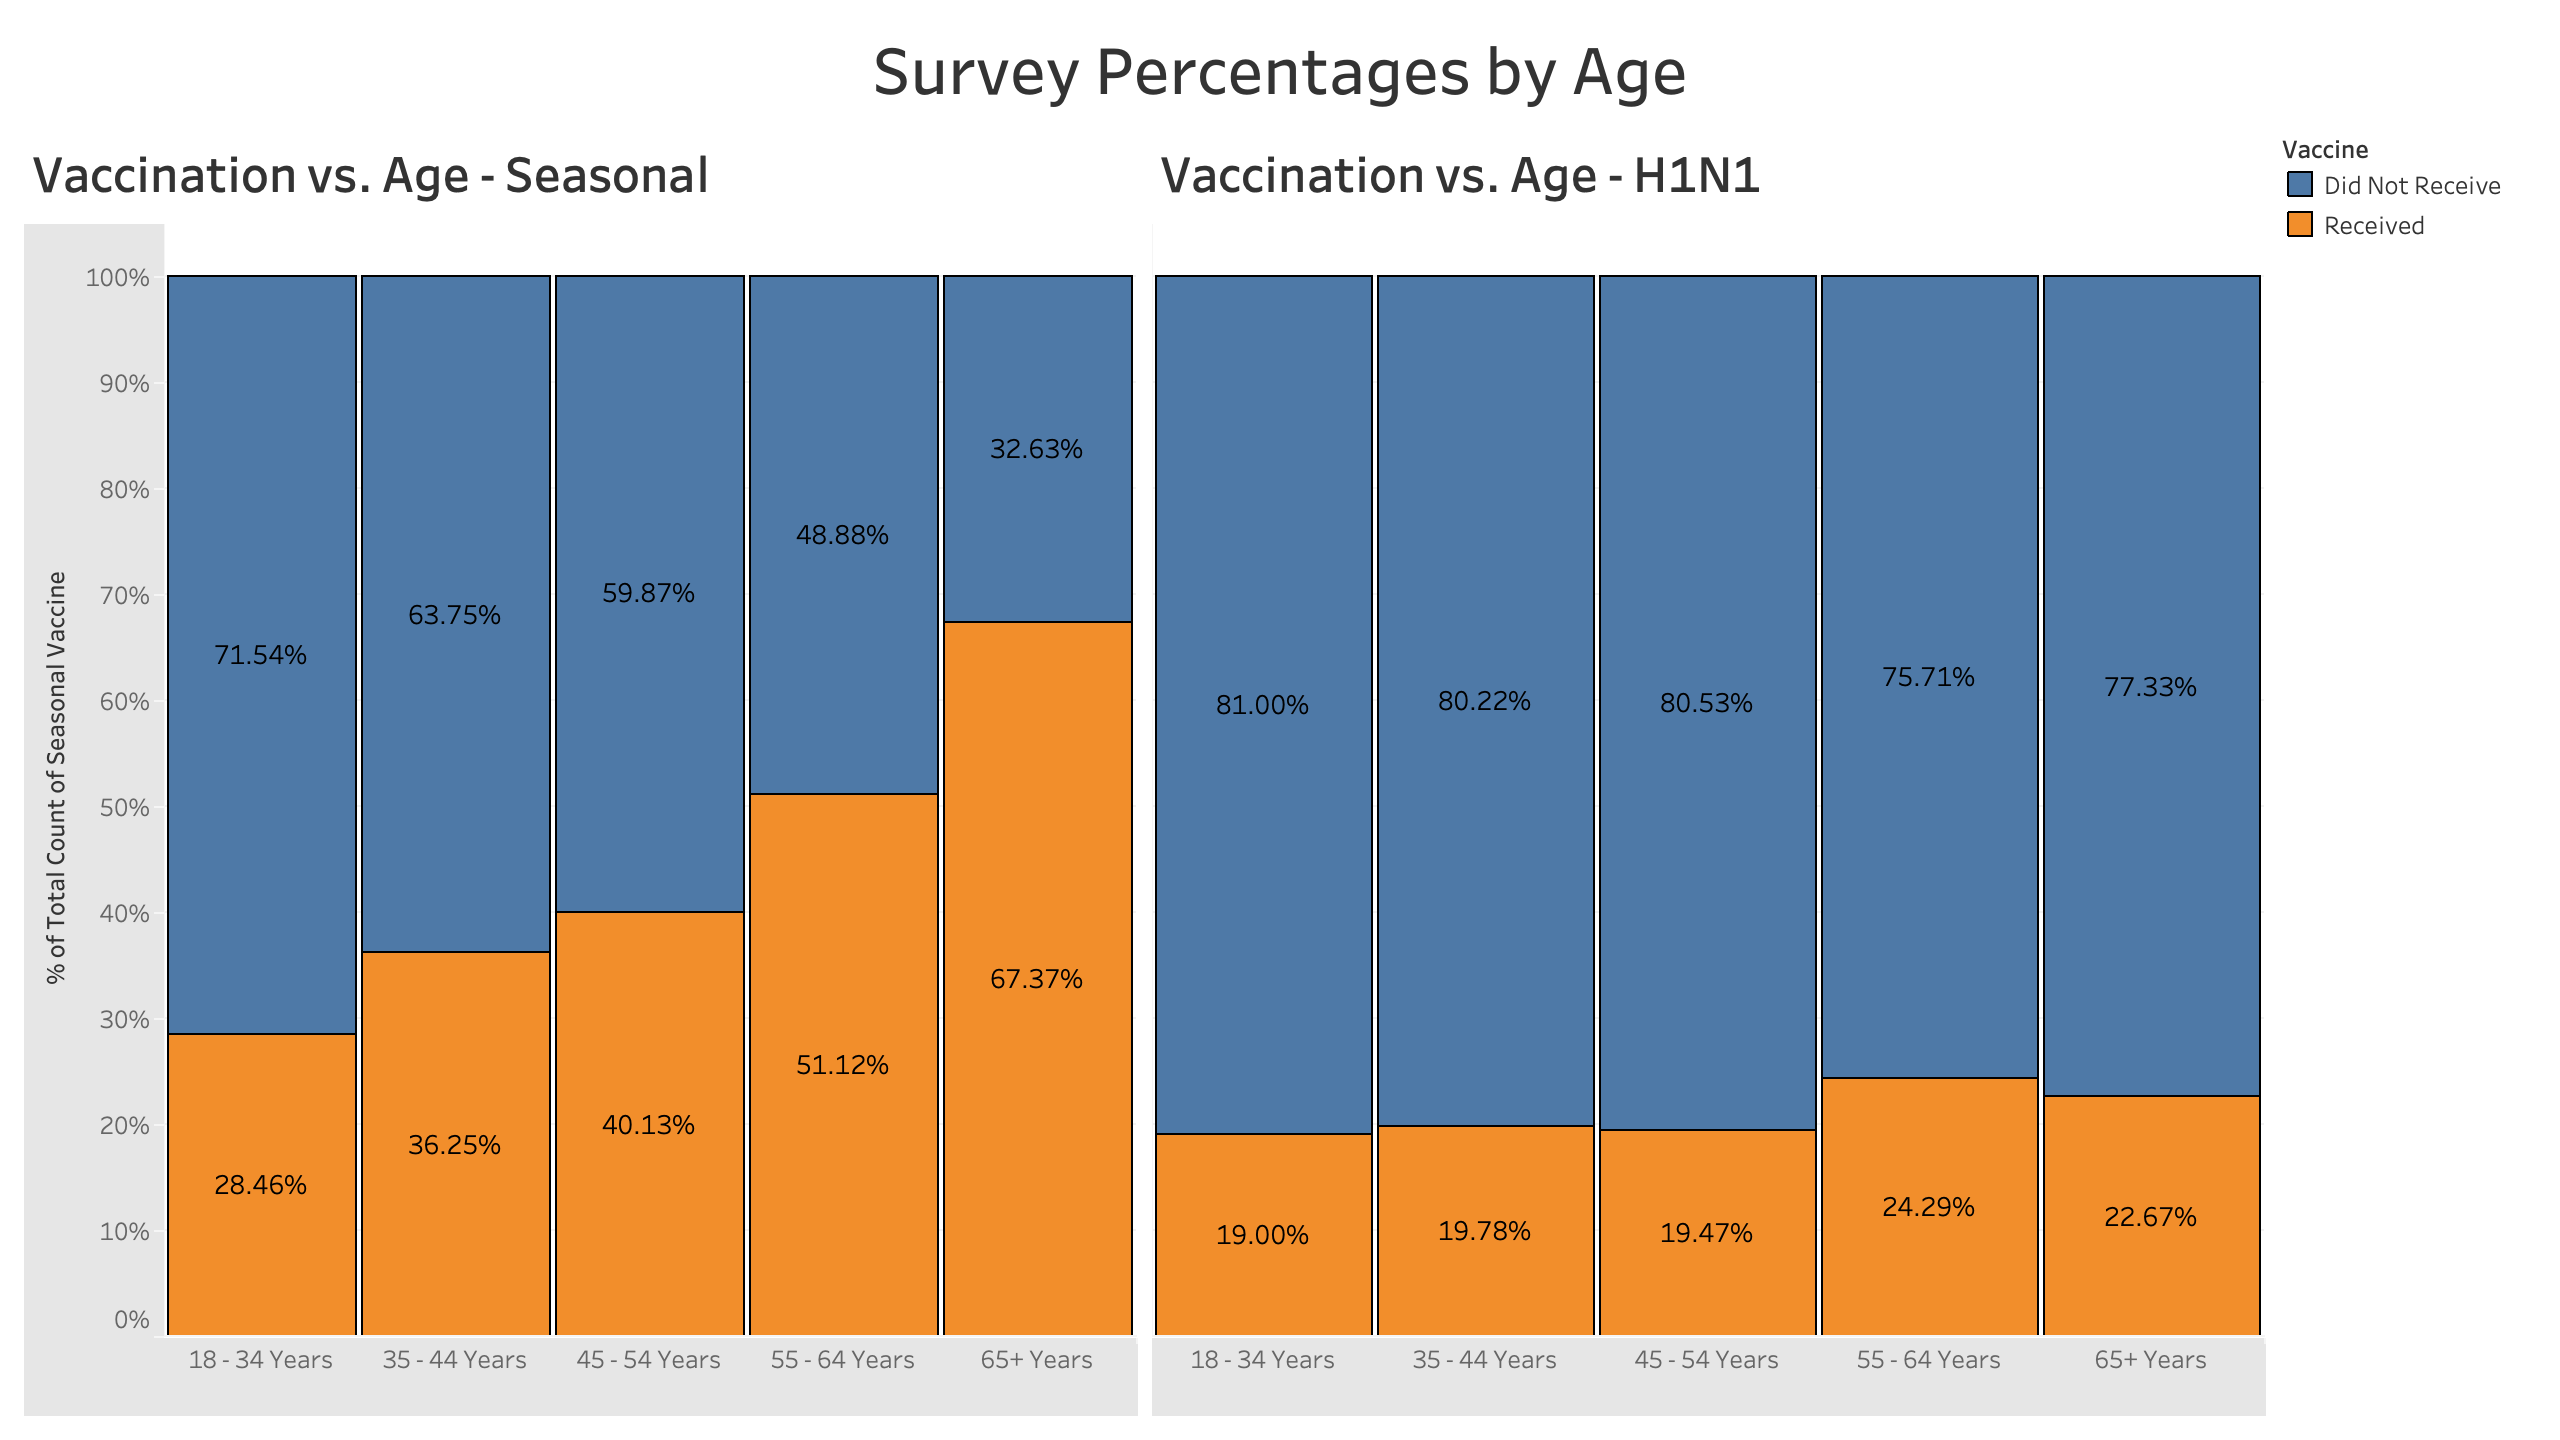

# One more model - competition baseline

This dataset is currently part of a competition on drivendata.org. The competition has conveniently provided their own baseline model on which participants can choose to improve if they so desire. We'll include it here so that we can gauge our progress by some external measure, but we'll need to train-test split and clean again, since their strategy was different from ours.

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, random_state=random_state)

In [128]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

In [129]:
numeric_columns = list(X.columns[X.dtypes == 'float64'].values)

In [130]:
X_train_reduced = X_train[numeric_columns]
X_test_reduced = X_test[numeric_columns]

In [131]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_reduced), columns=X_train_reduced.columns, index=X_train_reduced.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_reduced), columns=X_test_reduced.columns, index=X_test_reduced.index)

In [132]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(X_train_reduced)

X_train_imp = pd.DataFrame(imputer.transform(X_train_scaled), columns=X_train_scaled.columns, index=X_train_scaled.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test_scaled), columns=X_test_scaled.columns, index=X_test_scaled.index)

In [133]:
log_reg_h1n1 = LogisticRegression(penalty="l2", C=1)
log_reg_ssnl = LogisticRegression(penalty="l2", C=1)

log_reg_h1n1.fit(X_train_imp, y_train_h1n1)
log_reg_ssnl.fit(X_train_imp, y_train_ssnl);

In [134]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_imp)
y_hat_ssnl = log_reg_ssnl.predict(X_test_imp)

y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_imp)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_imp)

Recall for Competition Baseline - H1N1:    0.4043803418803419
Recall for Competition Baseline - SSNL:    0.7151559454191033

Precision for Competition Baseline - H1N1: 0.6503436426116839
Precision for Competition Baseline - SSNL: 0.7458703939008895

Accuracy for Competition Baseline - H1N1:  0.8273201724529158
Accuracy for Competition Baseline - SSNL:  0.7539142273655548

F1 score for Competition Baseline - H1N1:  0.49868247694334655
F1 score for Competition Baseline - SSNL:  0.7301903221793755

AUROC for Competition Baseline - H1N1:     0.8206886901112268
AUROC for Competition Baseline - SSNL:     0.8223370964270786


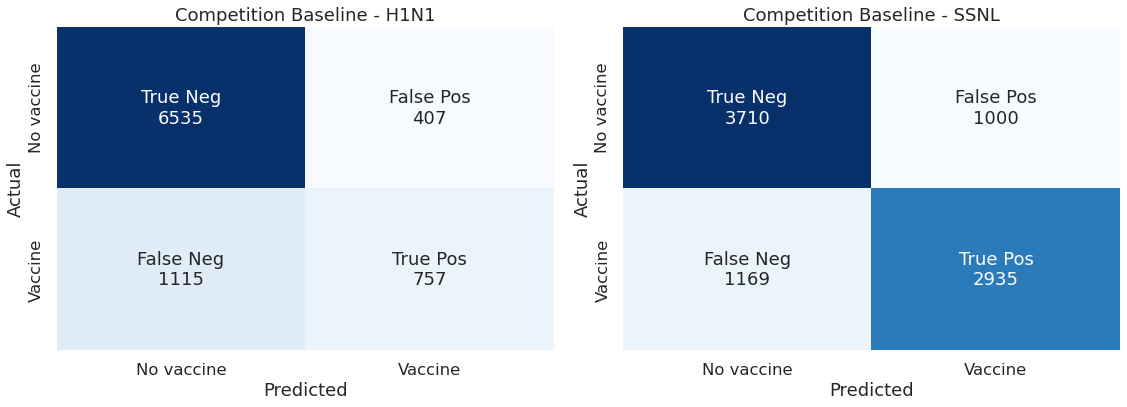

In [135]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['Competition Baseline - H1N1', 'Competition Baseline - SSNL'], keep_score=True)

# THE SLIDE

It's always a good idea to see the progress of our models. We'll graph that progress for a select few. Since multiple people on our team were running models simultaneously, it's not feasible to make a meaningful graph that shows models chronologically. Instead, we'll organize them in pairs (if we have pairs) of an untuned model with its tuned model, with the better-performing models to the right. We'll use the same order for both H1N1 and the seasonal flu though, so the best model may not be the rightmost model.

In [47]:
list(models_dict.keys())

['Tuned SVC - H1N1',
 'Tuned SVC - SSNL',
 'Simple Logistic - H1N1',
 'Simple Logistic - SSNL',
 'Untuned SVC - H1N1',
 'Untuned SVC - SSNL',
 'Tuned HistGradientBoost - H1N1',
 'Tuned HistGradientBoost - SSNL',
 'Untuned HistGradientBoost - H1N1',
 'Untuned HistGradientBoost - SSNL',
 'Tuned Random Forest - H1N1',
 'Tuned Random Forest - SSNL',
 'Untuned Random Forest - H1N1',
 'Untuned Random Forest - SSNL',
 'Untuned Naive Bayes - H1N1',
 'Untuned Naive Bayes - SSNL',
 'Tuned Naive Bayes - H1N1',
 'Tuned Naive Bayes - SSNL',
 'Competition Baseline - H1N1',
 'Competition Baseline - SSNL']

In [48]:
h1n1_models_to_graph = ['Competition Baseline - H1N1', 'Untuned Naive Bayes - H1N1', 'Tuned Naive Bayes - H1N1', 'Simple Logistic - H1N1', 'Untuned HistGradientBoost - H1N1', 'Tuned HistGradientBoost - H1N1', 'Untuned Random Forest - H1N1', 'Tuned Random Forest - H1N1', 'Untuned SVC - H1N1', 'Tuned SVC - H1N1']
ssnl_models_to_graph = ['Competition Baseline - SSNL', 'Untuned Naive Bayes - SSNL', 'Tuned Naive Bayes - SSNL', 'Simple Logistic - SSNL', 'Untuned HistGradientBoost - SSNL', 'Tuned HistGradientBoost - SSNL', 'Untuned Random Forest - SSNL', 'Tuned Random Forest - SSNL', 'Untuned SVC - SSNL', 'Tuned SVC - SSNL']

In [49]:
h1n1_graph_data = []

for model in h1n1_models_to_graph:
    h1n1_graph_data.append((model, models_dict[model]['scores']['precision'], models_dict[model]['scores']['accuracy']))
    
ssnl_graph_data = []

for model in ssnl_models_to_graph:
    ssnl_graph_data.append((model, models_dict[model]['scores']['precision'], models_dict[model]['scores']['accuracy']))

In [50]:
h1n1_graph_data

[('Competition Baseline - H1N1', 0.6503436426116839, 0.8273201724529158),
 ('Untuned Naive Bayes - H1N1', 0.37894736842105264, 0.6885061774616249),
 ('Tuned Naive Bayes - H1N1', 0.57243195785777, 0.8184200673904904),
 ('Simple Logistic - H1N1', 0.7244897959183674, 0.8534256832646949),
 ('Untuned HistGradientBoost - H1N1', 0.7373211963589077, 0.8558592287532759),
 ('Tuned HistGradientBoost - H1N1', 0.736318407960199, 0.8586671658554849),
 ('Untuned Random Forest - H1N1', 0.773015873015873, 0.8519281168101834),
 ('Tuned Random Forest - H1N1', 0.8135135135135135, 0.8309621864470236),
 ('Untuned SVC - H1N1', 0.7756024096385542, 0.8560464245600898),
 ('Tuned SVC - H1N1', 0.7650429799426934, 0.8567952077873455)]

In [51]:
ssnl_graph_data

[('Competition Baseline - SSNL', 0.7458703939008895, 0.7539142273655548),
 ('Untuned Naive Bayes - SSNL', 0.6583592938733126, 0.7079745413702733),
 ('Tuned Naive Bayes - SSNL', 0.6941885187810064, 0.7418569824035942),
 ('Simple Logistic - SSNL', 0.76814011676397, 0.7774241856982403),
 ('Untuned HistGradientBoost - SSNL', 0.7701761573125768, 0.7836016473231),
 ('Tuned HistGradientBoost - SSNL', 0.7665306122448979, 0.7811681018345189),
 ('Untuned Random Forest - SSNL', 0.7635983263598326, 0.7725570947210783),
 ('Tuned Random Forest - SSNL', 0.766107678729038, 0.7624485211531262),
 ('Untuned SVC - SSNL', 0.7689741451209341, 0.778172968925496),
 ('Tuned SVC - SSNL', 0.777027027027027, 0.7822912766754024)]

In [52]:
h1n1_xticklabels = []
h1n1_y_pre = []
h1n1_y_acc = []

for model_name, model_pre, model_acc in h1n1_graph_data:
    h1n1_xticklabels.append(model_name)
    h1n1_y_pre.append(model_pre)
    h1n1_y_acc.append(model_acc)

ssnl_xticklabels = []
ssnl_y_pre = []
ssnl_y_acc = []

for model_name, model_pre, model_acc in ssnl_graph_data:
    ssnl_xticklabels.append(model_name)
    ssnl_y_pre.append(model_pre)
    ssnl_y_acc.append(model_acc)

In [53]:
xtickabbrev = ['Competition Baseline',
               'Untuned Naive Bayes',
               'Tuned Naive Bayes',
               'Simple Logistic',
               'Untuned HistGradientBoost',
               'Tuned HistGradientBoost',
               'Untuned Random Forest',
               'Tuned Random Forest',
               'Untuned SVC',
               'Tuned SVC'
              ]

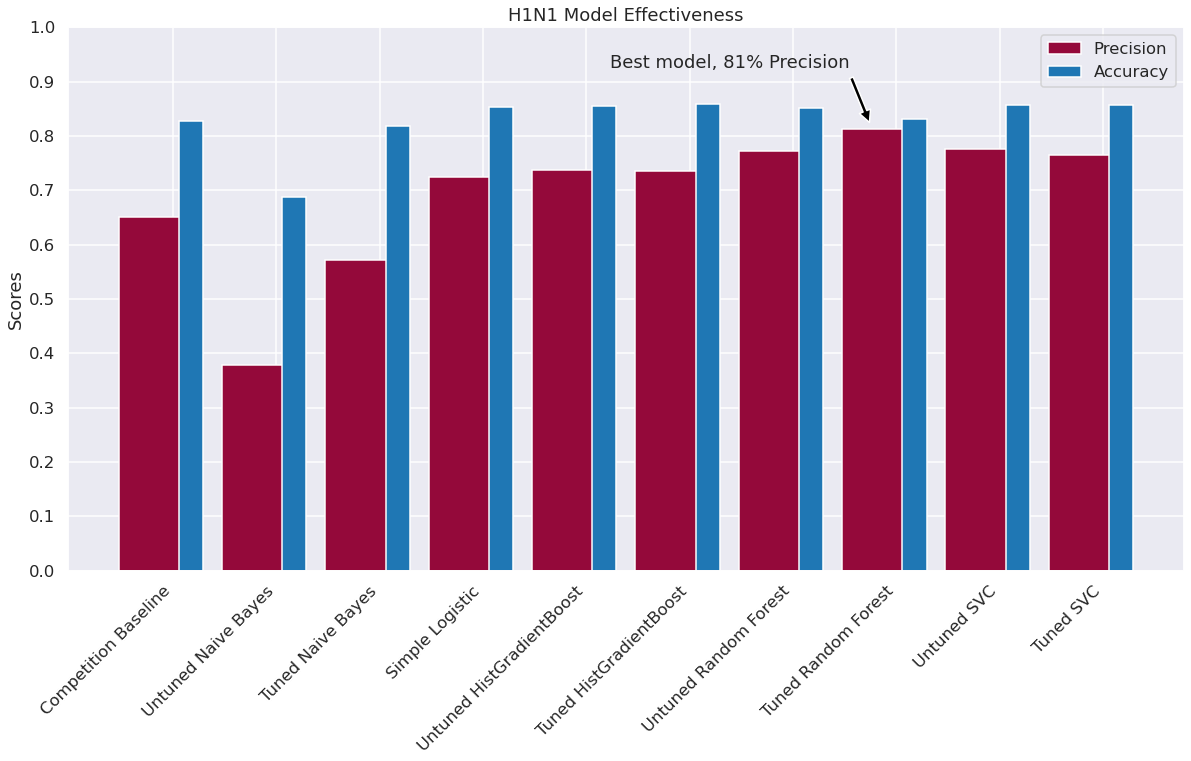

In [54]:
sns.set_style('darkgrid')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(20, 10))

width = .35

ax.bar(np.array(range(len(xtickabbrev))) - width/2, h1n1_y_pre, width*2, color='#94093a', label="Precision")
ax.bar(np.array(range(len(xtickabbrev))) + width/2, h1n1_y_acc, width/3*2, label="Accuracy")
ax.set(ylim=(0, 1))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_xticks(list(range(len(xtickabbrev))))
ax.set_xticklabels(xtickabbrev)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend()

ax.set_ylabel('Scores')
ax.set_title('H1N1 Model Effectiveness')
ax.annotate('Best model, 81% Precision', 
            xy=(6.75, .82),
            xytext=(0.7, .95), 
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', 
            verticalalignment='top'
           );
#fig.savefig('graphs/H1N1_models', dpi=300, transparent=True, bbox_inches='tight', pad_inches=1);

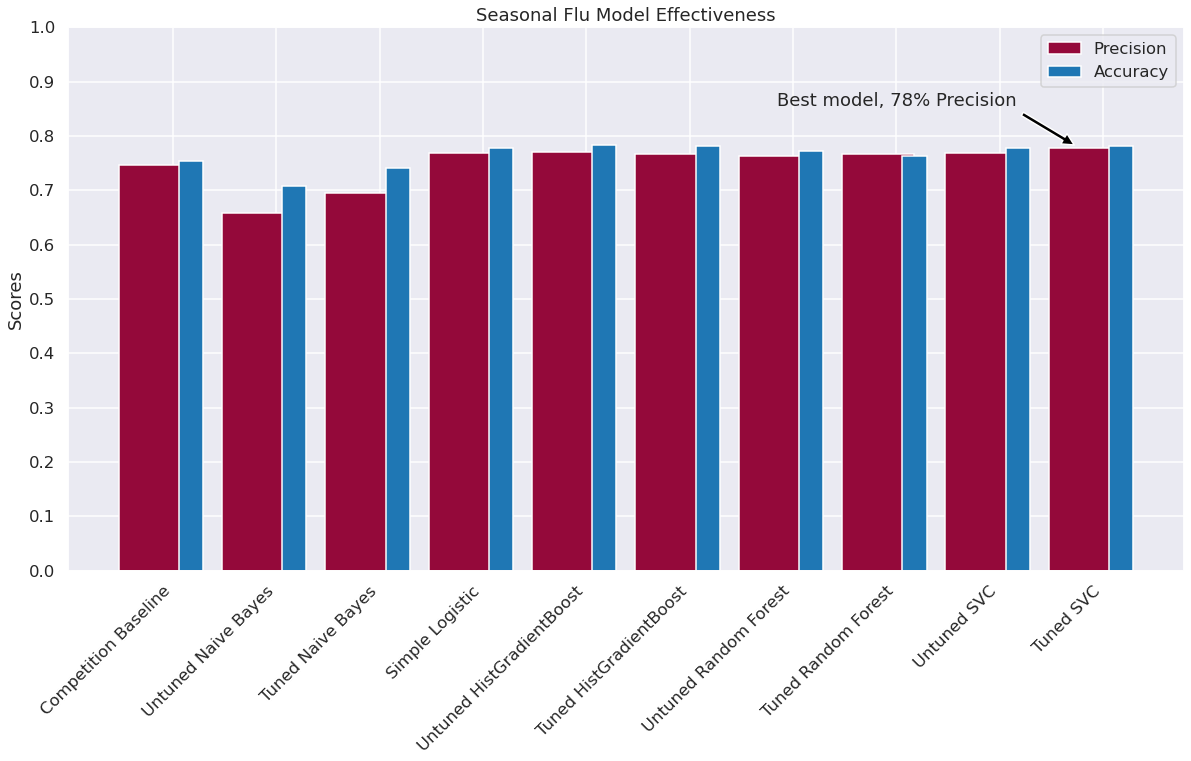

In [56]:
sns.set_style('darkgrid')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(20, 10))

width = .35

ax.bar(np.array(range(len(xtickabbrev))) - width/2, ssnl_y_pre, width*2, color='#94093a', label="Precision")
ax.bar(np.array(range(len(xtickabbrev))) + width/2, ssnl_y_acc, width/3*2, label="Accuracy")
ax.set(ylim=(0, 1))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_xticks(list(range(len(xtickabbrev))))
ax.set_xticklabels(xtickabbrev)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend()

ax.set_ylabel('Scores')
ax.set_title('Seasonal Flu Model Effectiveness')
ax.annotate('Best model, 78% Precision', 
            xy=(8.75, .78),
            xytext=(0.85, .88), 
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', 
            verticalalignment='top'
           );
#fig.savefig('graphs/SSNL_models', dpi=300, transparent=False, bbox_inches='tight', pad_inches=1);

# Conclusion

Based on the interpretations of our best models, we recommend the following to help the NIH increase vaccination rates:

1.) Emphasize to medical professionals the importance of consistently recommending vaccinations for their patients.

2.) Conduct a public awareness campaign about the safety and effectiveness of vaccines.

3.) Target outreach efforts to those groups who are more likely to get seasonal than the H1N1 (unmarried people, black people, those 65 and older, and middle class). These are groups we believe the NIH should target in the event of a pandemic as they may already be open to getting vaccinations but need more awareness about a novel contagion in order to receive an additional shot. More broadly, we also recommend targeting those groups unlikely to get the seasonal vaccines as a way to increase vaccine rates overall (18-34 year olds, Hispanic people, those living in poverty).

To better refine these suggestions, we suggest examining the data geographically to see if different parts of the country show reveal predictors for getting or not getting vaccines. The respondent's region of the country was noted during the survey but anonymized to protect their identity. Being able to study this data through the prism of geography may reveal how to adapt outreach efforts based on region. Secondly, we recommend supplementing this data with interviews by people who are more representative of the racial breakdown in the U.S. (this survey only has 8% black respondents and 6.5% Hispanic respondents).

We believe these suggestions with help the NIH move forward with increasing vaccine acceptance among the American population. There will be another pandemic. Having a population that is aware of the effectiveness of vaccinations and willing to receive them is one of the most powerful ways to blunt the next virus that goes viral.

# Appendix 1: For the Future: Model Stacking

One powerful tool in classification and regression problems is model stacking, or meta modeling. However, this requires either a pipeline compatible with the StackingClassifier class (which, ours is not, for some difficult to diagnose reason having to do with ColumnTransformers) or predictions for each model on the *entire* dataset, via cross-validation (which, because we chose to make our pipeline a little too convenient, we don't have). We can still test the principle though by applying a simple ensemble method, in this case majority rule voting, to see if something along these lines would yield any significant results. 

In [482]:
h1n1_df = pd.DataFrame()
ssnl_df = pd.DataFrame()

dummy_list_h1n1 = []
dummy_list_ssnl = []

for name, model in models_dict.items():
    if 'predictions' in model and name.endswith('H1N1') and 'tuned' in name:
        dummy_list_h1n1.append(pd.Series(model['predictions'][0]))
    elif 'predictions' in model and name.endswith('SSNL'):
        dummy_list_ssnl.append(pd.Series(model['predictions'][0]))
h1n1_df = pd.concat(dummy_list_h1n1, axis=1)
ssnl_df = pd.concat(dummy_list_ssnl, axis=1)

In [483]:
h1n1_df

,0,1,2,3
0,0,0,0,0
1,1,1,0,1
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
5337,1,1,1,1
5338,0,0,0,0
5339,0,0,0,0
5340,0,0,0,1


In [484]:
y_hat_stack_h1n1 = round((h1n1_df[0] + h1n1_df[1] + h1n1_df[2] + h1n1_df[3]) / 4)

In [485]:
print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_stack_h1n1)}')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_stack_h1n1)}')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_stack_h1n1)}')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_stack_h1n1)}')
#print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1[:,1])}')

Recall for H1N1:            0.4440528634361233
Precision for H1N1:         0.7671232876712328
Accuracy for H1N1:          0.8532384874578809
F1 score for H1N1:          0.5625


These scores are not terrible, though we didn't outperform our best models in precision or accuracy. However, applying a logistic regression to our combined results dataframe, that is, properly implementing a model stack, might produce noteworthy results. This would allow the new stacked model to learn how to properly weight each model and produce predictions that way, as opposed to simple majority rule voting. If, in the future, we were to attempt to achieve higher scores, this would be a procedure certainly worth exploring.

# Appendix 2: Exporting some additional graphs for presenting

Recall:    0.26519823788546254
Precision: 0.8135135135135135
Accuracy:  0.8309621864470236
F1 score:  0.39999999999999997


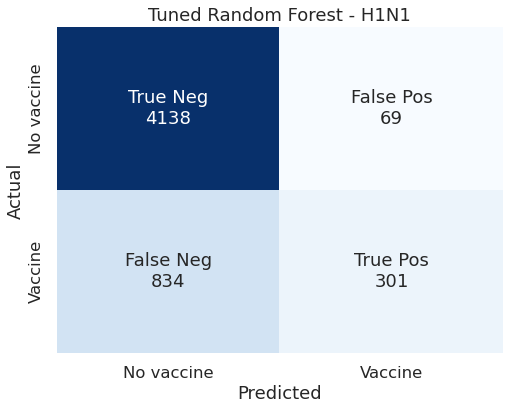

In [566]:
all_metrics(y_test_h1n1, get_predictions('Tuned Random Forest - H1N1')[0], y_score=None, model_name='Tuned Random Forest - H1N1', keep_score=False, save_fig=True, suppress_output=False)

Recall:    0.7434343434343434
Precision: 0.777027027027027
Accuracy:  0.7822912766754024
F1 score:  0.7598595911625025


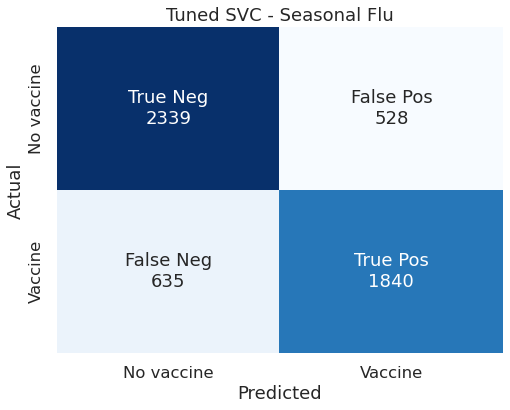

In [46]:
all_metrics(y_test_ssnl, get_predictions('Tuned SVC - SSNL')[0], y_score=None, model_name='Tuned SVC - Seasonal Flu', keep_score=False, save_fig=True, suppress_output=False)